In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import urllib.request as urllib2
#from urllib.request import urlopen
import json
import re
import urllib.parse
import pickle
from fa2 import ForceAtlas2
import collections
import powerlaw
import os
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#from nltk.stem import WordNetLemmatizer
from IPython.display import Markdown as md
import seaborn as sns
from PIL import Image

#from scipy.interpolate import interp1d
#from pathlib import Path
from wordcloud import WordCloud
from nltk.corpus import PlaintextCorpusReader as pcr
#from nltk.corpus import PlaintextCorpusReader
#from nltk.tokenize import WordPunctTokenizer
#import string
import community
from importlib import reload 
reload(community)
#from math import isnan
#import random
from fa2 import ForceAtlas2
import random
from bokeh.io import output_notebook, show
from bokeh.models import Range1d, Circle, MultiLine, NodesAndLinkedEdges
from bokeh.plotting import from_networkx
#from bokeh.palettes import Blues8
import bokeh.plotting.figure as bokeh_figure

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus
import pyLDAvis
import pyLDAvis.gensim_models
import warnings


import re
from bs4 import BeautifulSoup
#from IPython.core.display import display, HTML
import requests


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline 

# Project Star Wars

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_  
_Due date - **08/12/2021**_  
_Author - **s175393, s183998, and s212584**_  
_Website - [LINK](https://miamiya.github.io/Star_Wars_Trilogies/intro.html)_

---
## Table of Contents:
- [__Part 1: Motivation__](#moti)
- [__Part 2: Basic stats__](#bas_stat.)
    - [__Part 2.1: Creating the dataframe__](#creat_data.)
        - [__Part 2.1.1: Adding attributes__](#add_attri.)
    - [__Part 2.2: Creating the Star Wars network__](#creat_network.)
        - [__Part 2.2.1: Constructing the network__](#con.)
        - [__Part 2.2.2: Visualization of the network__](#vis_net.)
    - [__Part 2.3: Generating the text file for NLP analysis__](#txt_g.)
- [__Part 3: Analysis__](#ana.)
    - [__Part 3.1: Load files from basic stats__](#3_load.)
    - [__Part 3.2: Analysis of the network__](#ana_net)
        - [__Part 3.2.1: Analysis of largest degree counts__](#insta.)
        - [__Part 3.2.2: Analysis of degree distribution__](#degree.)
    - [__Part 3.3: Word clouds__](#word.)
        - [__Part 3.3.1 Word clouds for alliance based on the wiki__](#word_al.)
        - [__Part 3.3.2 Word clouds for 5 main characters based on wiki__](#word_character_5.)
        - [__Part 3.3.3 Word clouds for Anakin/Darth Vader based on movies scripts__](#word_script.)
        - [__Part 3.3.4 Word clouds for the two trilogies based on movies scripts__](#word_character.)
    - [__Part 3.4: Community analysis__](#com.)
    - [__Part 3.5: Sentiment analysis__](#sent.)
        - [__Part 3.5.1: Analysis of Wikipage__](#S_wiki.)
        - [__Part 3.5.2: Analysis of Movie Scipts__](#S_script.)
    - [__Part 3.6: Hidden topic modeling__](#htm.)
        - [__Part 3.6.1: Movie Scipts__](#htm_script.)
        - [__Part 3.6.2: Communities__](#htm_com.)
- [__Part 4: Discussion__](#dis)
- [__Part 5: Contribution__](#contri)

---
# Part 1: Motivation
<a id='moti'></a>

## What is your dataset?

We are looking at the APIs of characters from the Star Wars cinematic universe (Movies 1-9). We extract the dataset from [Wookepedia](https://starwars.fandom.com/wiki/Main_Page) and additionally, we analyze the dialogues from movies 1-6 (We haven't included dialogues from movies 7-9 because we didn't find them in good formatting).

## Why did you choose these particular datasets?

We grew up with these movies and we want to learn more about the interactions of these characters. We chose this specific dataset because we believe it would give promising results with a large network and interesting interactions. Additionally, we chose movie dialogues so we can compare how the movies and some characters (e.g. Anakin) change over time.

## What was your goal for the end user's experience?

Our goal was to extract useful information regarding the Star Wars characters and their interactions. Also, we want to demonstrate to the user a large network analysis. Finally, we want to provide a fun and interactive web interface for the user. Both Star Wars fanatics and newcomers can find interesting information on our website:

# [Website](https://miamiya.github.io/Star_Wars_Trilogies/intro.html)

---
# Part 2: Basic stats
<a id='bas_stat.'></a>

## Write about your choices in data cleaning and preprocessing

We mostly use regex to extract the information we needed such as character name and attributes such as homeworld and affiliation. 

An example with an excerpt of the API for General Kenobi:

|name=Obi-Wan Kenobi
|homeworld=[[Stewjon]]<ref name="USW NE">''[[Ultimate Star Wars, New Edition]]''</ref> in depth analysis of data cleaning for extracting characters, text and attributes can be seen on [__Part 2.1: Creating the dataframe__](#creat_data.). Data cleaning for movie scripts to extract character (speaker) and the dialogue as a dateframe can be seen on [__Part 3.3.3 Word clouds for Anakin/Darth Vader based on movies scripts__](#word_script.) and on [__Part 3.3.4 Word clouds for the two trilogies based on movies scripts__](#word_character.). The preprocessing of text for creating txt files is on [__Part 2.3: Generating the text file for NLP analysis__](#txt_g.).

## Write a short section that discusses the dataset stats

We have in total 1397 unique characters in our data frame. Additionally, we have extracted and added some attributes: 1) Movie Appearance 2) Homeworld 3) Species 4) Gender 5) Affiliation, and based on that we created 6) Alliance. These attributes were chosen as they are interesting and can show some interesting characteristics in the network, while attributes like eye color are irrelevant.

The Affiliation attribute is a special case, as characters have many affiliations to many different groups. Thus we only accept certain affiliations (see list in [__Part 2.1.1: Adding attributes__](#add_attri.)), and convert them to 5 alliance types: Jedi, Sith, Good, Evil, Mixed, Unknown. 

## Part 2.1: Creating the dataframe
<a id='creat_data.'></a>

We will start by creating a data frame containing all the characters in the chosen Star Wars movies, meaning all movies in the Skywalker saga, Star Wars 1-9. The data frame is created such that we will get an easy overview of all characters and their associated attributes. The information of characters will come from the [Star Wars fandom wiki](https://starwars.fandom.com/wiki/Main_Page). There exists a unique wiki page for each movie, where all characters appearing in the movie will be listed. An example is:  
<img src=data/wiki_appearances.PNG alt="wiki_appearances" width="500"/>  
The characters in our data frame will be from _Characters_ and _Creatures_ in the web pages. Furthermore, we will only extract the characters categorized as cannon, which means we will ignore legend characters.

Before we can extract the characters, we need to define how the wiki page hyperlinks to other pages. We see two types of links: `[[xxxx]]` and `{{....|characters|xxx|...}}` where in both cases `xxx` represent the page name which the hyperlink links to. We have thus defined a function `extract_char(text)` which takes a text and returns all the hyperlinks inside the text file.

In [2]:
## Define function for finding and extracting hyperlinks
def extract_char(text): 

    # Saving all the links from text in one list 
    All_Links = []

    # Find type 1 [[...]]
    Links1 = re.findall(r'(?<=\[\[).*?(?=\])', text) # Finding the right type
    for link in Links1:
        # To tesst if we have type [[...|...]]
        split = re.search(r'^.*?(?=\|)', link) # We only extract xxx from [[xxx|yyy]]
        if split:
            All_Links.append(split.group())
        else: 
            All_Links.append(link)
            
    # Find type 2 {{...|characters|xxx|....}}
    Links2 = re.findall(r'(?<=characters\|).*?(?=\|)', text)
    for link in Links2:
        All_Links.append(link)

    return(All_Links) #Return all linked charaters 

We will start with initializing the movies and the base information to get the URL. The characters will initially be saved inside a list. Furthermore, we will save which movies a character appears in as a dictionary.

In [3]:
## Initialization for extracting all characters 
# Movie 1-6
movies_1 = ["Star_Wars:_Episode_I_The_Phantom_Menace",\
    "Star_Wars:_Episode_II_Attack_of_the_Clones",\
        "Star_Wars:_Episode_III_Revenge_of_the_Sith",\
            "Star_Wars:_Episode_IV_A_New_Hope",\
                "Star_Wars:_Episode_V_The_Empire_Strikes_Back",\
                    "Star_Wars:_Episode_VI_Return_of_the_Jedi"]

# Movie 7-9
Movies_2 = ["Star_Wars:_Episode_VII_The_Force_Awakens",\
            "Star_Wars:_Episode_VIII_The_Last_Jedi",\
                "Star_Wars:_Episode_IX_The_Rise_of_Skywalker"]

# Initialize url 
baseurl = "https://starwars.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# initialize empty list to save in 
char = []
appearance = {}

# Initailzation for the information of which movie character appears in
movie_nr = 1

Looping through the prequel and the original trilogies to extract the characters. The characters in the source code are listed as a table, thus we will extract part of the source file which correspond to _Characters_ or _Creatures_ then use the `extract_char` function to extract all the character that appears in the given movie.

In [4]:
# Extract characters and creatures from the prequel and the orginal trilogy
for i in movies_1:
    # Load text
    title = "titles=" + i
    queryChar = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    response = urllib2.urlopen(queryChar) # Load wiki 
    text = response.read().decode('utf-8')

    # Extract the charaters 
    text_char = re.search(r'c\-characters.*?\|l\-characters\=', text).group() 
    text_char = re.sub(r'\{\{.*?(\}\})','',text_char, flags=re.DOTALL)
    char_appering = extract_char(text_char)

    # Adding the attribute that they appers in movie i 
    for name in char_appering:
        if name in appearance:
            appearance[name].append(movie_nr)
        else:
            appearance[name] = [movie_nr]
    # Adding the characters 
    char.append(char_appering)


    # Extract the creatures 
    text_Creature = re.search(r'c\-creatures.*?\|l\-creatures\=', text).group() 
    text_Creature = re.sub(r'\{\{.*?(\}\})','',text_Creature, flags=re.DOTALL)
    creature_appering = extract_char(text_Creature)

    # Adding the attribute that they appers in movie i 
    for name in creature_appering:
        if name in appearance:
            appearance[name].append(movie_nr)
        else:
            appearance[name] = [movie_nr]
    # Adding the creatures 
    char.append(creature_appering)

    # Go to the next movie
    movie_nr+=1

We will then run it for the sequel trilogy. The reason for running to a different loop is that the layout is different. The wiki pages now no longer contain legend characters and only have cannon characters, which means we need to change the method of how we limit our text.

In [5]:
# Extract characters and creatures from the sequel
for i in Movies_2:
    # Load text
    title = "titles=" + i
    queryChar = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    response = urllib2.urlopen(queryChar) # Load wiki 
    text = response.read().decode('utf-8')

    # Extract the charaters 
    text_char = re.search(r'characters\=.*?\|creatures\=', text).group() 
    text_char = re.sub(r'\{\{.*?(\}\})','',text_char, flags=re.DOTALL)
    char_appering = extract_char(text_char)

    # Adding the attribute that they appers in movie i 
    for name in char_appering:
        if name in appearance:
            appearance[name].append(movie_nr)
        else:
            appearance[name] = [movie_nr]
    # Adding the characters 
    char.append(char_appering)


    # Extract the creatures 
    text_Creature = re.search(r'creatures\=.*?\|events\=', text).group() 
    text_Creature = re.sub(r'\{\{.*?(\}\})','', text_Creature, flags=re.DOTALL)
    creature_appering = extract_char(text_Creature)

    # Adding the attribute that they appers in movie i 
    for name in creature_appering:
        if name in appearance:
            appearance[name].append(movie_nr)
        else:
            appearance[name] = [movie_nr]
    # Adding the creatures 
    char.append(creature_appering)

    # Go to the next movie
    movie_nr+=1

We have now extracted all the characters and in which movie they appear. We will then create a data frame for our data.

In [6]:
# Unpack list of lists
all_char = [item for sublist in char for item in sublist]

## Create a dataframe 
characters_df = pd.DataFrame(set(all_char)) # Removing duplicates in list and convert to dataframe
characters_df.rename(columns={0:'Name'}, inplace=True) # Rename to Name
characters_df['Appearance'] = characters_df['Name'].apply(lambda x: list(appearance[x])) # Add column of appearance
characters_df['Name'] = [name.encode().decode('unicode_escape') for name in characters_df['Name']] #Dealing with special symbols 
all_char = characters_df['Name'] # List of all characters 

### Part 2.1.1: Adding attributes
<a id='add_attri.'></a>

We would like to add some attributes which we find interesting to each character. We have chosen to add _homeworld, species, gender, affiliation_ and _alliance_. An example for a character in the final data frame should look like this:  
<img src=data/characters_df_ex.PNG alt="characters_df_ex" width="900"/>  

To extract the attributes, we will need to load each of the character's wiki page and save the information in a dictionary. Thus, we start with initializing empty dictionaries for each attribute and the pattern of how the attribute appears in the URL.

In [7]:
# Initialize dictionaries for attributes 
affiliation = {}
gender_dic = {}
species_dic = {}
homeworld_dic = {}

# Define pattern for extraction 
pattern_sq_1 = r'.+?(?=\[)'
pattern_sq_2 = r'\[.*?\]'
pattern_homeworld = r'((?<=(Homeworld\n))).*?(?=(\n\n\n))'
pattern_class = r'((?<=(Class\n))).*?(?=(\n\n\n))'
pattern_species = r'((?<=(Species\n))).*?(?=(\n\n\n))'
pattern_gender = r'(?<=(Gender\n)).*?(?=\])'
pattern_affiliation = r'((?<=(Affiliation\(s\)\n))|(?<=(Affiliation\n))).*?(?=(\n\n\n))'

# Base url
base = 'https://starwars.fandom.com/wiki/'

To extract the attributes we will load each character's wiki page and using beautiful soup extract the information. 

In [8]:
# Loop over all character 
for name in all_char:
    # Remove space in name
    name_c = name.replace(" ","_")
    
    # The URL for extracting the net worth 
    URL = base + name_c

    # Load URL in b4s
    page = requests.get(URL)
    soup = BeautifulSoup(page.content)

    # Extracting only the table in the wikipage 
    list_wiki = []
    section = soup.findAll("section")
    for i in section:
        list_wiki+=i.get_text()
    text = ''.join(list_wiki)

    ## Extract attributes and add it to the dictionaries
    # Homeworld 
    test_h = re.search(pattern_homeworld, text)
    list_h = []
    if test_h: 
        for s in re.findall(pattern_sq_1,test_h.group()):
            list_h.append(re.sub(pattern_sq_2,'',s))
    homeworld_dic[name] = list_h

    # Species  
    test_c = re.search(pattern_class, text)
    if test_c:
        species_dic[name] = ['Droid']
    else: 
        test_s = re.search(pattern_species, text)
        list_s = []
        if test_s: 
            for s in re.findall(pattern_sq_1,test_s.group()):
                list_s.append(re.sub(pattern_sq_2,'',s))
        species_dic[name] = list_s

    # Gender 
    test_g = re.search(pattern_gender, text)
    list_g = []
    if test_g: 
        for s in re.findall(pattern_sq_1,test_g.group()):
            list_g.append(re.sub(pattern_sq_2,'',s))
    gender_dic[name] = list_g

    
    # Affiliations 
    test_af = re.search(pattern_affiliation, text)
    list_af = []
    if test_af: 
        for s in re.findall(pattern_sq_1, test_af.group()):
            list_af.append(re.sub(pattern_sq_2,'',s))
    affiliation[name] = list_af

We have now extracted the attributes _homeworld, species, gender_, and _affiliation_. A new column is created in the character data frame for each attribute to store this information. 

In [9]:
## Add attributes 
characters_df['Homeworld'] = characters_df['Name'].apply(lambda x: homeworld_dic[x]) #homeworld 
characters_df['Species'] = characters_df['Name'].apply(lambda x: species_dic[x]) #species
characters_df['Gender'] = characters_df['Name'].apply(lambda x: gender_dic[x]) #gender
characters_df['Affiliation'] = characters_df['Name'].apply(lambda x: affiliation[x]) #affiliation

We are still missing the _alliance_ attribute which we mentioned as an interesting attribute. From the movies we know we can categorize characters as good or evil based on the _affiliation_. We have decided to create _alliance_ which is based on _affiliation_, thus a character will be one of the 6 different _alliances_ we have defined.  

We have classified some _affiliation_ of being in the good alliance and some in the evil alliance. Furthermore, we have a special class for the Jedi and Sith. The alliance mix is created for a character who changes alliance through the movies. Since there are many unique _affiliations_ and some are not clear, we are not able to categorize all of them and these will be categorized as unknown. In the following code block, you can see how we have defined the _affiliations_ for the different categories.

In [10]:
# Add attribute for alliance
# Defining alliance 
good_alliance = ['Resistance', 'Alliance','Galactic Republic', 'Rebel', 'New Republic', 'Alliance to Restore the Republic']
good_alliance_jedi = ['Jedi Order']
evil_alliance = ['First Order','Crime lord','Imperial','Final Order'] 
evil_alliance_sith = ['Sith']

We will create a function `split_alliance` which will return the list of alliances based on the _affiliations_ of characters. 

In [11]:
# Define function to compute
def split_alliance(df):
    alliance_list = []
    for _, row in df.iterrows():   
        temp = row['Affiliation']
        species = row['Species'] # This is for Droids, since Droids can't be Jedi or Sith

        # Initialzing the alliance, thus it is set to unkown if it does not fit any condiction
        alliance = None
        
        # Condition for determine the alliance
        if list(set(temp).intersection(good_alliance)):
            alliance = 'Good'
        if list(set(temp).intersection(good_alliance_jedi)):
            if species:
                if species[0] == 'Droid':
                    alliance = 'Good'
                else:
                    alliance = 'Jedi'
            else:
                alliance = 'Jedi'
        if list(set(temp).intersection(evil_alliance)):
            if not alliance:
                alliance = 'Evil'
            else:
                alliance = 'Mix'
        if list(set(temp).intersection(evil_alliance_sith)):
            if alliance in ['Good', 'Jedi', 'Mix']:
                alliance = 'Mix'
            elif species == 'Droid':
                alliance = 'Evil'
            else:
                alliance = 'Sith'

        alliance_list.append(alliance)  
    return alliance_list

As for the other attributes, we will save the _alliance_ as a new column in the characters data frame. We have now finished creating the data frame containing all information needed for each character as a pandas data frame. This data frame will be saved as a .csv file, _characters.csv_.

In [14]:
# Compute and Alliance to character dataframe 
characters_df['Alliance'] = split_alliance(characters_df)

# Adding coloum File_Name for later useage
characters_df['File_Name'] = characters_df['Name'].str.replace("/","_")

# Save as csv file 
characters_df.to_csv('data/characters.csv',index=False)

We have in total 1397 unique characters in our data frame.

In [15]:
characters_df.head()

Name Appearance                  Homeworld        Species  \
0          Weazel        [1]                 [Tatooine]        [Human]   
1  Jaiyna Sibinth        [9]                         []        [Human]   
2      Orrimaarko        [6]                         []  [Dressellian]   
3     Sturg Ganna        [8]  [Sturg Ganna's homeworld]   [Whippomorn]   
4         Ugloste        [5]                         []     [Ugnaught]   

     Gender                                     Affiliation Alliance  \
0    [Male]                       [Hutt Clan, Cloud-Riders]     None   
1  [Female]                                              []     None   
2    [Male]  [Alliance to Restore the Republic, Resistance]     Good   
3    [Male]                                              []     None   
4    [Male]                                              []     None   

        File_Name  
0          Weazel  
1  Jaiyna Sibinth  
2      Orrimaarko  
3     Sturg Ganna  
4         Ugloste

## Part 2.2: Creating the Star Wars network 
<a id='creat_network.'></a>

### Part 2.2.1: Constructing the network 
<a id='con.'></a>
We will create a graph representing how characters are connected. The nodes in the graph are characters. If character _a_'s wiki page has a hyperlink to character _b_, then there will be a link/edge from node _a_ to node _b_. We will start with initializing the needed information to loop through all characters and add to the graph.

In [16]:
## Initialization 
# Initialization for URL 
baseurl = "https://starwars.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Create empty directed graph
DG_SW = nx.DiGraph()

# Creating list of all characters with _ as space
all_char_ = characters_df['Name'].str.replace(' ', '_').to_numpy()

We will now loop through all characters. The attributes are added to the nodes as node_attributes.

In [17]:
## Creating the graph by looping over all characters and adding links
for _, row in characters_df.iterrows():
  
  # Remove space in name
  name = str(np.char.replace(row[0]," ", "_"))
  
  # Getting the values for the attributes
  Appearance = row[1]
  Homeworld = row[2]
  Species = row[3]
  Gender = row[4]
  Affiliation = row[5]
  Alliance = row[6]

  # Load the character url 
  title = "titles=" + name
  queryChar = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

  # Dealing with special symbols such as é
  temp = ''.join(chr(ord(c)) for c in urllib.parse.quote(queryChar))
  temp = np.char.replace(temp, '%3A', ':')
  temp = np.char.replace(temp, '%3F', '?')
  temp = np.char.replace(temp, '%3D', '=')
  queryChar = str(np.char.replace(temp, '%26', '&'))

  # Load wiki 
  response = urllib2.urlopen(queryChar) 
  wiki_char = response.read().decode('utf-8')

  # Finding length of content (amount word in wiki page)
  pattern = re.compile(r'\w+')
  lotc = len(pattern.findall(wiki_char))

  # Add character and the attributes to graph 
  DG_SW.add_node(name, Appearance = Appearance, Homeworld=Homeworld, lotc = lotc,
  Species=Species, Gender = Gender, Affiliation = Affiliation, Alliance = Alliance)

  # Finding the linked character to the given character and add it as edges
  links = extract_char(wiki_char)
  for link in links:
    link = link.replace(' ', '_')
    if link in all_char_ and link != name:
      DG_SW.add_edge(name, link)


We have now created a graph containing all characters. We will also extract the giant connected component (GCC) from the graph, which will be used for visualization. Both graphs will be saved such that they can be accessed easily.

In [18]:
# Convert to undirected
G_SW = DG_SW.to_undirected()

# Sort to find the GCC 
CCs_list = sorted(nx.connected_components(G_SW), key=len, reverse=True)
# Create the GCC 
SW_DG_GCC = DG_SW.subgraph(CCs_list[0]).copy()
G_SW_GCC = SW_DG_GCC.to_undirected()

#saving as pickle format for quick and easy access
with open('data/DG_SW.gpickle', 'wb') as handle:
    pickle.dump(G_SW, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/SW_DG_GCC.gpickle', 'wb') as handle:
    pickle.dump(SW_DG_GCC, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Part 2.2.2: Visualization of the network
<a id='vis_net.'></a>

In this part, we will visualize the network based on different factors using the GCC graph. In all the plots the node size is based on the degree of the node. In the first plot we wish to color the nodes based on the _Alliance_ for a character, thus we have created a function `map_color` which will be able to generate the corresponding color based on _Alliance_. We have defined the colors as:  
| _Alliance_ | Color  |
|------------|--------|
| Good       | Green  |
| Evil       | Purple |
| Jedi       | Blue   |
| Sith       | Red    |
| Mix        | Orange |
| Unknown    | Pink   |

In [20]:
# Function for mapping colors 
def map_color(x):
    if x == 'Good':
        return 'green'
    elif x == 'Jedi':
        return 'blue'
    elif x == 'Sith':
        return 'red'
    elif x == 'Evil':
        return 'purple'
    elif x == 'Mix':
        return 'darkorange'
    else: 
        return 'pink'

To create a plot with nice positioning for nodes we will use `ForceAtlas2`. For the different plot we will use different parameters for the `ForceAtlas2`. The optimal positions are saved for using in the webpage. 

In [18]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=220.0,

                        # Log
                        verbose=True)

# Compute optimal posistion
positions_still = forceatlas2.forceatlas2_networkx_layout(G_SW_GCC, pos=None, iterations=2000)

# Save the position for the webpage 
with open('data/positions_still.pickle', 'wb') as handle:
    pickle.dump(positions_still, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 2000/2000 [01:03<00:00, 31.36it/s]

BarnesHut Approximation  took  8.35  seconds
Repulsion forces  took  53.48  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.88  seconds


We start with creating a simple visualization to get a quick glance at the graph.

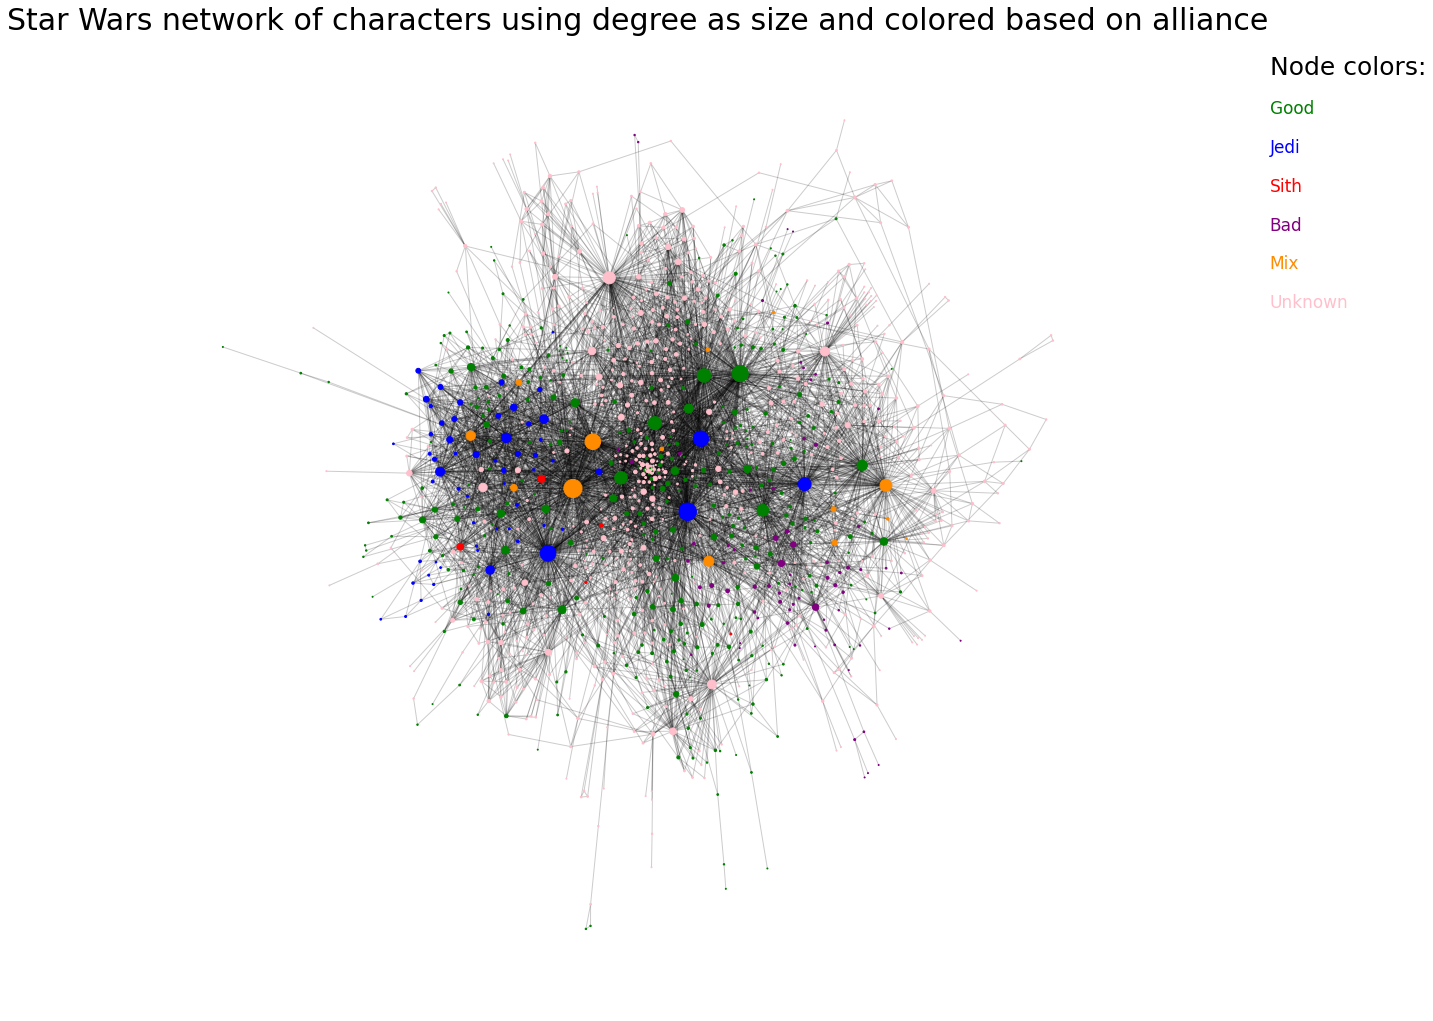

In [19]:
## Visulization based on Alliance and degree
# Setting node size based on degree
node_size = [val for (_, val) in G_SW_GCC.degree()]

# Compute the color for each nodes 
colors = [map_color(G_SW_GCC.nodes[n]['Alliance']) for n in G_SW_GCC.nodes()]

# Plotting the graph
plt.figure(figsize = [18, 18])
nx.draw_networkx_nodes(G_SW_GCC, positions_still, node_size=node_size, node_color = colors, alpha=1)
nx.draw_networkx_edges(G_SW_GCC, positions_still, alpha=0.2, arrows=False)
plt.axis('off')

# Indicating node colors
y = 0.85 # This is the starting y position for the figure legend
plt.figtext(1, y, 'Node colors:', size = 25, color = 'black')
color_node = ['green','blue','red', 'purple', 'darkorange', 'pink']
role_node = ['Good', 'Jedi', 'Sith', 'Bad', 'Mix', 'Unknown']
y -= 0.03
for i in range(len(color_node)):
    plt.figtext(1, y, str(role_node[i]), size = 17, color = color_node[i])
    y -= 0.03

plt.title("Star Wars network of characters using degree as size and colored based on alliance", fontsize=30)
plt.show()

We see that there are a lot of nodes and there are not many evil and Sith characters. To get a better understanding we will create an interactive graph.  
Create a new position with changed weight for the variables.

In [20]:
forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=False,  # Dissuade hubs
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,

        # Tuning
        scalingRatio=0.015,
        strongGravityMode=False,
        gravity=10.5,

        # Log
        verbose=True)
positions_inter_z = forceatlas2.forceatlas2_networkx_layout(G_SW_GCC, pos=None, iterations=3000)

# Save the position for the webpage 
with open('data/positions_inter_z.pickle', 'wb') as handle:
    pickle.dump(positions_inter_z, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 3000/3000 [01:20<00:00, 37.44it/s]

BarnesHut Approximation  took  12.09  seconds
Repulsion forces  took  64.83  seconds
Gravitational forces  took  0.32  seconds
Attraction forces  took  0.34  seconds
AdjustSpeedAndApplyForces step  took  1.36  seconds


The interactive graph will again be color based on the _alliance_ and the size is based on the degree. In contrast to the first plot, we will scale the node size such we can see a more significant difference between nodes. Furthermore, we have added some of the attributes to the interactive graph.

In [21]:
from matplotlib import colors
output_notebook()

## adding degree as an attribute
degrees = dict(nx.degree(G_SW_GCC))
nx.set_node_attributes(G_SW_GCC, name='degree', values=degrees)

## Adjusting the node size to be based on the degree 
number_to_adjust_by = 2
adjusted_node_size = dict([(node, degree*0.17 + number_to_adjust_by) for node, degree in nx.degree(G_SW_GCC)])
nx.set_node_attributes(G_SW_GCC, name='adjusted_node_size', values=adjusted_node_size)

Alliance_colors = dict([(n, map_color(G_SW_GCC.nodes[n]['Alliance'])) for n in G_SW_GCC.nodes()])
nx.set_node_attributes(G_SW_GCC, name='Alliance_colors', values=Alliance_colors)

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from network to size and color by
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'Alliance_colors'

#Choose a title
title = 'Star Wars interactive Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
    ("Character", "@index"),
        ('Species', '@Species'),
        ('Gender', '@Gender'),
        ('Alliance', '@Alliance'),
        ('Homeworld', '@Homeworld'),
        ('Apperance', '@Appearance'),
        ("Degree", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = bokeh_figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1), title=title)


#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_SW_GCC, positions_inter_z, scale=1, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.1, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)
show(plot)


Loading BokehJS ...

The plot can also be found in our [webpage](https://miamiya.github.io/Star_wars/SW_Network.html). 

We can see that the main characters for movies are the ones with the largest node size. We see none of the larger nodes are categorized as evil or Sith, this also corresponds with the bad guys in the movies are mainly without names. We see the largest node is _Anakin Skywalker_ (Darth Vader) and he is categorized as a mix, which is corrected due to the transformation in the prequels, he turns from the light side to the dark side. _Darth Sidious_ is also categorized as a mix, this is not completely correct. He is evil all through the movies, but due to him pretending to be good.

We will now look at the communities for our GCC network. We will talk more about the communities in Part 5 Community Analysis. Here we will simply create the communities and take a look at the plot for it. 

In [104]:
# Create communities using Lauvian 
partition = community.best_partition(G_SW_GCC, random_state=4)
with open('data/partition.pickle', 'wb') as handle:
    pickle.dump(partition, handle, protocol=pickle.HIGHEST_PROTOCOL)

Again, creating new positions with new weighted variables.

In [22]:
# Save the position for the webpage 
forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=False,  # Dissuade hubs
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,

        # Tuning
        scalingRatio=85.0,
        strongGravityMode=False,
        gravity=0.001,

        # Log
        verbose=True)
positions_inter = forceatlas2.forceatlas2_networkx_layout(G_SW_GCC, pos=None, iterations=2000)

with open('data/positions_inter.pickle', 'wb') as handle:
    pickle.dump(positions_inter, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 2000/2000 [01:13<00:00, 27.08it/s]

BarnesHut Approximation  took  9.09  seconds
Repulsion forces  took  62.31  seconds
Gravitational forces  took  0.24  seconds
Attraction forces  took  0.26  seconds
AdjustSpeedAndApplyForces step  took  0.98  seconds


We will now plot the network, where the colors are based on the communities. 

In [31]:
from matplotlib import colors
output_notebook()

## adding degree as an attribute
degrees = dict(nx.degree(G_SW_GCC))
nx.set_node_attributes(G_SW_GCC, name='degree', values=degrees)

## Adjusting the node size to be based on the degree 
number_to_adjust_by = 0
adjusted_node_size = dict([(node, degree + number_to_adjust_by) for node, degree in nx.degree(G_SW_GCC)])
nx.set_node_attributes(G_SW_GCC, name='adjusted_node_size', values=adjusted_node_size)

## For color base on community
all_colors_dict = dict(colors.CSS4_COLORS)
community_class = {}
community_color = {}
dict_community = {}
## Loop through each community in the network 
for nr in range(0, max(partition.values()) + 1):
    dict_community[nr] = [name for name, comm in partition.items() if comm == nr]

for nr, character_list in dict_community.items():

    # Choose a random color entry
    color_k = random.randint(0, len(all_colors_dict) - 1)
    
    # Retrieve the color HEX for that random color
    color = all_colors_dict[list(all_colors_dict)[color_k]]
    
    # Remove the color already chosen by one community, so that we don't end up with duplicate colors by accident
    all_colors_dict.pop(list(all_colors_dict)[color_k])

    # Add the individuale community number and color for each node 
    for node in character_list:
        community_class[node] = nr
        community_color[node] = color

    # Set as node attribute 
    nx.set_node_attributes(G_SW_GCC, name='community_class', values=community_class)
    nx.set_node_attributes(G_SW_GCC, name='community_color', values=community_color)


#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'community_color'

#Choose a title!
title = 'Star Wars interactive Network based on communities'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
    ("Character", "@index"),
        ('Species', '@Species'),
        ('Gender', '@Gender'),
        ('Alliance', '@Alliance'),
        ('Homeworld', '@Homeworld'),
        ('Apperance', '@Appearance'),
        ("Degree", "@degree"),
        ("Community", "@community_class")
]

#Create a plot — set dimensions, toolbar, and title
plot = bokeh_figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-5500.1, 5500.1), y_range=Range1d(-5500.1, 5500.1), title=title)

#Create a network graph object
network_graph = from_networkx(G_SW_GCC, positions_inter, scale=1, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(radius=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(radius=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(radius=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.051, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)
show(plot)

Loading BokehJS ...

We see mainly three communities that contain large nodes. Furthermore, we see mainly the communities are based on the trilogies. The prequel trilogy is Community: 1. The original trilogy is Community: 5. The sequel trilogy is Community: 4. There are characters that appear in multiple movies, but they are primarily categorized in the first movie they appear in or as another community that is not as prominent.

## Part 2.3: Generating the text file for NLP analysis 
<a id='txt_g.'></a>

We will create a folder containing txt files for all the characters. This will later be used for creating word clouds and more. 

`clean_text` function is used to filter unwanted symbols and clear unwanted formatting of words

In [2]:
wnl = nltk.WordNetLemmatizer()
def clean_text(text, *args):
    for name in args:
        name = re.sub(r'\(|\)','',name)
        for n in re.split(r'\s',name):
            text = re.sub(n,'',text)

    text = re.sub(r'===.*?===','',text) # removes paterns
    text = re.sub(r'==.*?==','',text) 
    text = re.sub(r'\{\{.*?\}\}','',text)

    tokens = word_tokenize(text) # tokennizing the text
    tokens = [wnl.lemmatize(w.lower()) for w in tokens if (w.lower() not in stopwords.words('english') and w.isalpha())] #changes to lower case and removes unwanted types

    final_words = [word for word in tokens if len(word) > 3] #removing words under length 4
    return final_words

Loading the API for the characters. We use the `clean_text` function to clean the pages. Furthermore, we use another content format (prop=extracts&exlimit=1&explaintext) which only provides the text without page formating.

In [ ]:
#characters_df

baseurl = "https://starwars.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat = "format=json"

def create_txt(char):
    # file name
    File_name =  char.replace("/","_")

    #path to generate the txt files.
    filepath = os.getcwd() + '/data/characters/' + File_name + '.txt'

    # Load the character url 
    title = "titles=" + char.replace(" ","_")
    queryChar = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    temp = ''.join(chr(ord(c)) for c in urllib.parse.quote(queryChar))
    temp = np.char.replace(temp, '%3A', ':')
    temp = np.char.replace(temp, '%3F', '?')
    temp = np.char.replace(temp, '%3D', '=')
    queryChar = str(np.char.replace(temp, '%26', '&'))
    response = urllib2.urlopen(queryChar) # Load wiki
    wiki_char = json.load(response)
    page_id = list(wiki_char['query']['pages'].keys())[0]
    text_temp = wiki_char['query']['pages'][page_id].get('extract',None)

    #only if query has text to extract
    if text_temp != None:
        text_sring = ' '.join(clean_text(text_temp,char,'Star Wars'))

        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(text_sring)
    
    return File_name

characters_df['File_Name'] = characters_df['Name'].apply(create_txt)

---
# Part 3: Analysis
<a id='ana.'></a>

## Part 3.1: Load files from basic stats
<a id='3_load.'></a>

In this section, we will load all the data generated in part 2: Basic stats, such that we don't need to run the section since it is time-consuming. 

In [2]:
# Load the character dataframe 
characters_df = pd.read_csv('data/characters.csv')

# Load the network 
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)

# Create to undirected graph for plot
G_SW_GCC = SW_DG_GCC.to_undirected()

# Load the partition 
with open('data/partition.pickle', 'rb') as handle:
    partition = pickle.load(handle)


## Part 3.2: Analysis of the network for giant connected component
<a id='ana_net'></a> 

### Part 3.2.1: Analysis of largest degree counts
<a id='insta.'></a> 

The node and link count of our giant connected component (GCC)

In [3]:
print(f'Number of nodes in GCC is {SW_DG_GCC.number_of_nodes()}.')
print(f'Number of links in GCC is {SW_DG_GCC.number_of_edges()}.')

Number of nodes in GCC is 1224.
Number of links in GCC is 7608.


In [4]:
# Create dataframe for in-degree, out-degree, and total degree
data = []
for node in SW_DG_GCC:
    data.append((node, SW_DG_GCC.degree(node), SW_DG_GCC.in_degree(node), SW_DG_GCC.out_degree(node))) 
SW_degree = pd.DataFrame(data, columns =['Name', 'Degree', 'in_degree', 'out_degree'])

Let's start by taking a look at the characters with the highest degree in the undirected graph:

In [5]:
print("Characters with highest degrees:\n", SW_degree[['Name','Degree']].sort_values("Degree", ascending=False).head(5))

Characters with highest degrees:
                           Name  Degree
1             Anakin_Skywalker     441
16              Luke_Skywalker     372
4                     Han_Solo     314
39              Obi-Wan_Kenobi     313
18  Leia_Skywalker_Organa_Solo     303


Unsurprisingly given that we are in the Skywalker saga (Movies 1-9), we see a lot of Skywalkers. Furthermore, Anakin/Darth Vader is one/the main character in movies 1-6, whereas no other characters have the same significance in more than 3 movies. 

Looking at the directed graph we see new characters:

In [6]:
print("\nCharacter with highest in-degree:\n", SW_degree[['Name','in_degree']].sort_values("in_degree", ascending=False).head(5))
print("\nCharacter with highest out-degree:\n", SW_degree[['Name','out_degree']].sort_values("out_degree", ascending=False).head(5))


Character with highest in-degree:
                 Name  in_degree
1   Anakin_Skywalker        323
16    Luke_Skywalker        296
4           Han_Solo        247
21     Darth_Sidious        241
39    Obi-Wan_Kenobi        238

Character with highest out-degree:
                           Name  out_degree
1             Anakin_Skywalker         118
18  Leia_Skywalker_Organa_Solo          82
16              Luke_Skywalker          76
39              Obi-Wan_Kenobi          75
4                     Han_Solo          67


Anakin is still the character with the largest degree both in/out. However, Darth Sidious has a higher in-degree than both Obi-Wan and Leia. This is unsurprising as Darth Sidious/Palpatine, is the main villain in the Skywalker Saga. But for movies 1-3 and 7-9, he works as a puppeteer behind the scenes. Thus a lot of characters will reference him, as they are controlled/influenced by him.

Leia has a higher out-degree compared to in-degree and degree. This also makes sense she is a front person organizing the resistance.

### Part 3.2.2: Analysis of degree distribution
<a id='degree.'></a> 

Here our goal is to check the properties of our GCC ie. if it's scale-free and thus follows a power law.

First, we'll find the degree sequence for in and out-degree.

In [7]:
degree_sequence_in = sorted([d for _, d in SW_DG_GCC.in_degree()])  # degree sequence
degreeCount_in = collections.Counter(degree_sequence_in)
deg_in, cnt_in = zip(*degreeCount_in.items())

#The distribution of out-degree
degree_sequence_out = sorted([d for _, d in SW_DG_GCC.out_degree()])  # degree sequence
degreeCount_out = collections.Counter(degree_sequence_out)
deg_out, cnt_out = zip(*degreeCount_out.items())

Ploting the degree distribution.

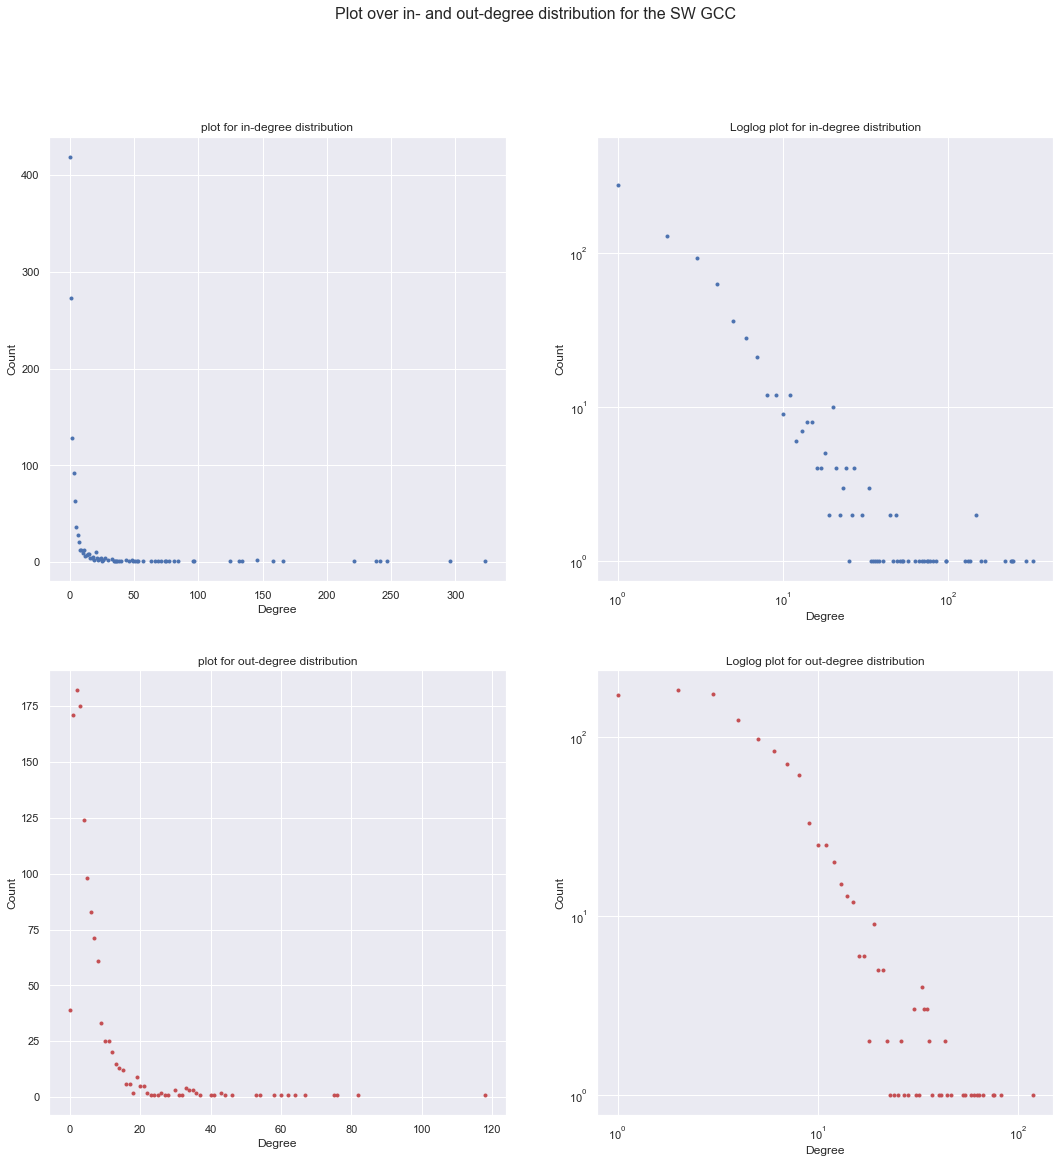

In [8]:
sns.set()
plt.figure(figsize = [18, 18])
plt.suptitle("Plot over in- and out-degree distribution for the SW GCC", fontsize=16)

#Plot in-degree
subax1 = plt.subplot(221)
plt.plot(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for in-degree distribution')
subax2 = plt.subplot(222)
plt.loglog(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for in-degree distribution')

#Plot out-degree
subax1 = plt.subplot(223)
plt.plot(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for out-degree distribution')
subax2 = plt.subplot(224)
plt.loglog(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for out-degree distribution')

plt.show()


At a quick glance it seems clear the two distributions follow a power law, but let's take a closer look.

Using the degree sequence (`degree_sequence_in` and `degree_sequence_out`) we can fit a power law. This will be done using the `powerlaw.Fit` function with three imporant parameters _xmin_ = 1, _degree sequence_ + 1 and _discrete = True_.

**degree sequence + 1**

We add with 1 because the power law function is $k^{-\gamma}$ meaning a degree of 0 would be $$P(0) = 0^{-\gamma} = -\inf$$ 

**xmin = 1**

This is done such that the fit starts from our lowest degree (0+1)

**discrete = True** 

because the degree sequence is discrete

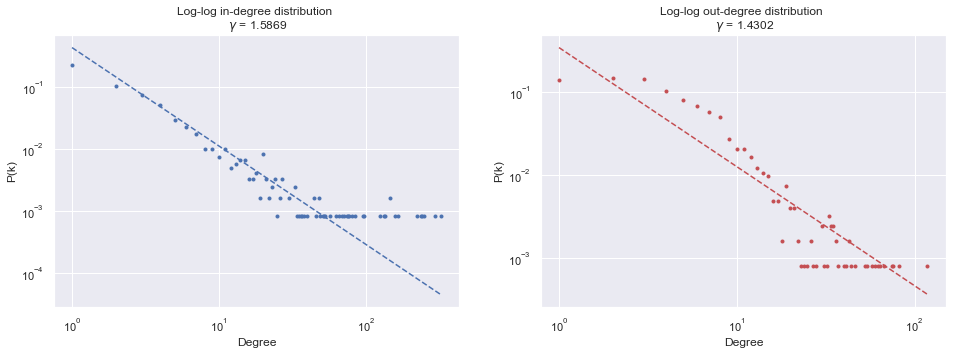

In [29]:
# plot for in_degree
plt.figure(figsize = [16, 5])
subax1 = plt.subplot(121)
plt.loglog(deg_in, np.array(list(cnt_in))/np.size(degree_sequence_in), '.') # the degree probability
fit = powerlaw.Fit(np.array(degree_sequence_in)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit pdf') # plotting the power law fit as a line
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.title('Log-log in-degree distribution \n $\gamma$ = '+ str(round(fit.power_law.alpha,4)))

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# plot for out_degree
subax2 = plt.subplot(122)
plt.loglog(deg_out, np.array(list(cnt_out))/np.size(degree_sequence_out), '.r') # the degree probability
fit = powerlaw.Fit(np.array(degree_sequence_out)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'r',linestyle='--',label='fit pdf') # plotting the power law fit as a line
plt.title('Log-log out-degree distribution \n $\gamma$ = '+ str(round(fit.power_law.alpha,4)))
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.show()

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

For the network we get that the degree exponents are:
\begin{align}
\gamma_{in} &= 1.59 \\
\gamma_{out} &= 1.43
\end{align} 

Looking at the figures directly above it seems power law is a good fit for the in- and out-degree distribution, meaning it's a scale-free network.
  
For the network exponents $\gamma$ we see that they are quite low, which means the probability of high degree node $\langle k\rangle$ is exponentially high. This we can see from the power-law given that $$P(k) = k^{-\gamma}$$

The fact that $\gamma_{in} < \gamma_{out}$ is very unusual. When comparing this to the [Network Science Book](http://networksciencebook.com/chapter/4#scale-free) section 4.4 it never holds true (except for email where it makes sense it's reversed). Importantly given that our graph is based on the [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) which follows the same format as Wikipedia, where $\gamma_{in} > \gamma_{out}$ [Wikipedia Network](https://arxiv.org/abs/physics/0602149) page 2, this property is highly unusual. Finally, looking at the degree counts for in/out-degree we see that there are nodes with much higher in-degree than out-degree. Thus the power-law fit must be a little off. Looking at the plot above, we also see that there seems to be a reference to the lower degree for the blue graph (in-degree) compared to the red graph (out-degree). Looking at the red graph (out-degree) this bias happens because there are a lot of nodes in the middle with higher probability which we see in the form of a little top. Compare this to the blue graph (in-degree) where the middle part much more closely follows our fit. 

Looking at the value of the exponents ($\gamma$) they also seem extremely low when compared to the Wikipedia network in [Wikipedia Network](https://arxiv.org/abs/physics/0602149) page 2 (2.15,2.57), as it is on average 0.5 and 1 lower for $\gamma_{in}$ and $\gamma_{out}$ respectively. This results in an order of magnitude higher probability and high degree node in our network, even though nodes with much higher degree exist in the Wikipedia network. This is due to the fact that our network is much smaller, meaning a much higher uncertainty. When taking the mean of the two networks we've created: Zelda (From Assignment 2) and Star Wars (This project)
\begin{align}
\gamma_{in_{combine}} &= \frac{1.59 + 3.34}{2} = 2.47\\
\gamma_{out_{combine}} &= \frac{1.43 + 4.41}{2} = 2.92,
\end{align}
we see that it closely resembles the ones found for the [Wikipedia Network](https://arxiv.org/abs/physics/0602149) (2.15,2.57).

Looking at the [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) and thinking of its real-world properties, it would make sense that $\gamma_{in}>\gamma_{out}$ as many articles will reference main characters (like Luke Skywalker), but the article for Luke Skywalker won't reference all the characters back. This is also known as the 80/20 rule, which is also applicable to many other real-world situations like a social network, Citation Network, etc, where the few (20) are in control of the many (80).

For a final power-law fit, we'll also look at the undirected graph and compare to a random graph (ER graph):

In [10]:
# Create the total undirected network 
SW_G_GCC = SW_DG_GCC.to_undirected().copy()

To create a random graph with the same probability as the Star Wars network we use ([Network Science Book](http://networksciencebook.com/chapter/4#scale-free)) $$\langle k\rangle=p(N-1) \Longrightarrow p = \frac{\langle k\rangle}{N-1}, $$
where $\langle k\rangle$ is the average degree for the undirected star wars graph.

In [11]:
# Number of nodes
N = SW_DG_GCC.number_of_nodes() 

# Average degree 
k = [d for _, d in SW_DG_GCC.degree()] #list of degrees in the Zelda BotW network
k_mean = np.mean(k) # average degree

# probability 
p = k_mean/(N-1)

# Generate directed ER network of same size and p 
G_ER = nx.erdos_renyi_graph(n = N, p = p, directed =True)

Then we can find the degree sequence.

In [12]:
#The distribution of degree for undirected
degree_sequence_undir_SW = sorted([d for _, d in SW_G_GCC.degree()])  # degree sequence
degreeCount_undir_SW = collections.Counter(degree_sequence_undir_SW)
deg_SW, cnt_SW = zip(*degreeCount_undir_SW.items())

#The distribution of degree for undirected random graph
G_ER_undir = nx.erdos_renyi_graph(n = N, p = p)
degree_sequence_undir_ER = sorted([d for _, d in G_ER_undir.degree()])  # degree sequence
degreeCount_undir_ER = collections.Counter(degree_sequence_undir_ER)
deg_ER, cnt_ER = zip(*degreeCount_undir_ER.items())

With this degree sequence we can plot it and compare to our undiredted star wars graph, and do a power law fit.

No handles with labels found to put in legend.


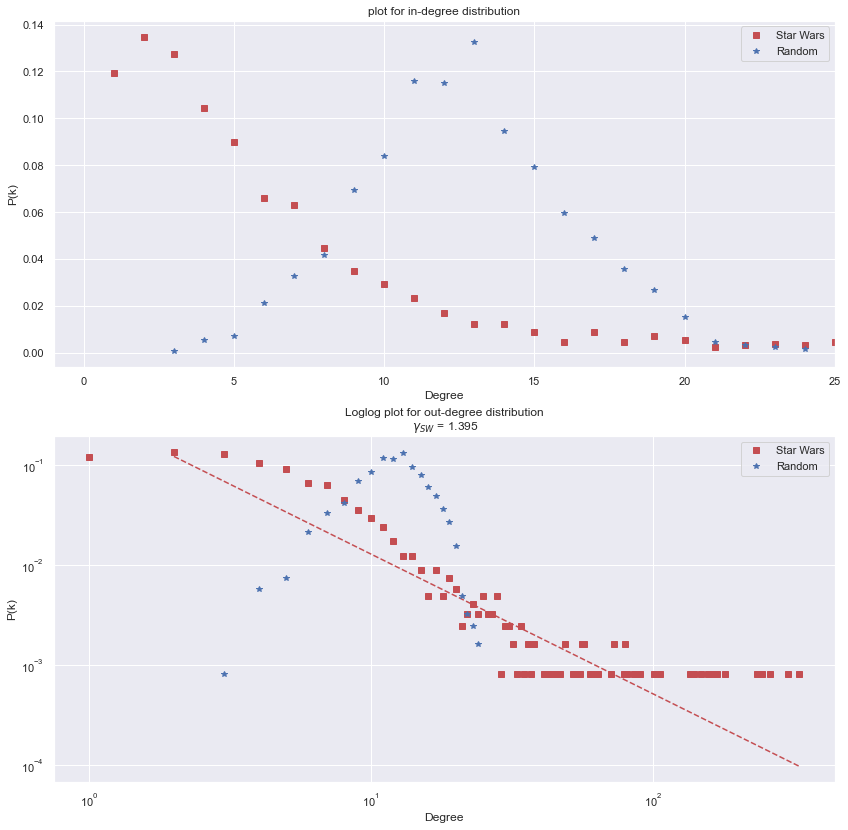

In [13]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.figure(figsize = [14, 14])
subax1 = plt.subplot(211)
p1, = plt.plot(deg_SW, np.array(list(cnt_SW))/np.size(degree_sequence_undir_SW), 'sr') # degree probability of undirected SW graph
p2, = plt.plot(deg_ER, np.array(list(cnt_ER))/np.size(degree_sequence_undir_ER), '*b') # degree probability of undirected ER graph
plt.legend(loc="upper left")
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.xlim([-1,25])
plt.legend([p1, p2],["Star Wars", "Random"])
plt.title('plot for in-degree distribution')

subax2 = plt.subplot(212)
p1, = plt.loglog(deg_SW, np.array(list(cnt_SW))/np.size(degree_sequence_undir_SW), 'sr') # degree probability of undirected SW graph
fit = powerlaw.Fit(np.array(degree_sequence_undir_SW)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'r',linestyle='--',label='fit pdf') # plotting the power law fit as a line
p2, = plt.loglog(deg_ER, np.array(list(cnt_ER))/np.size(degree_sequence_undir_ER), '*b') # degree probability of undirected ER graph
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.legend([p1, p2],["Star Wars", "Random"])
plt.title('Loglog plot for out-degree distribution\n $\gamma_{SW}$ = '+ str(round(fit.power_law.alpha,4)))

plt.show()

From the plot above, it is clear that the ER graph does not follow a power law, but that the undirected Star Wars network does. We can also see that the random graph follows a typical Poisson distribution. 

Finally, we see that with the combination of high degree nodes from the in-degree distribution and the high probability of middle degree nodes from out-degree distribution, we get the power-law fit with the lowest $\gamma = 1.40$, which is also too low when compared to other networks (exactly as we did for in/out-degree distribution). 

Looking at degree statistics for the ER graph:

In [14]:
# Degree distribution for in- and out-degree 
degree_sequence_in_ER = sorted([d for _, d in G_ER.in_degree()])  # degree sequence
degreeCount_in_ER = collections.Counter(degree_sequence_in_ER)
deg_in_ER, cnt_in_ER = zip(*degreeCount_in_ER.items())

degree_sequence_out_ER = sorted([d for _, d in G_ER.out_degree()])  # degree sequence
degreeCount_out_ER = collections.Counter(degree_sequence_out_ER)
deg_out_ER, cnt_out_ER = zip(*degreeCount_out_ER.items())

print('The maximum in-degree in the random network is ', max(degree_sequence_in_ER))
print('The minimum in-degree in the random network is ', min(degree_sequence_in_ER))

print('The maximum out-degree in the random network is ', max(degree_sequence_out_ER))
print('The minimum out-degree in the random network is ', min(degree_sequence_out_ER))

The maximum in-degree in the random network is  26
The minimum in-degree in the random network is  3
The maximum out-degree in the random network is  25
The minimum out-degree in the random network is  3


We also see that there are no nodes with a high degree count exactly as expected, given that it does not possess the scale-free property.

## Part 3.3: Word clouds
<a id='word.'></a> 

The word clouds help us extract meaning from large amounts of text by providing the most descriptive words in a document or corpus. We are extracting the most descriptive words based on two functions the Term Count (TC) and Inverse Document Frequency (IDF). TC function returns how many times a specific term (word) appears in a given document. IDF function returns a value related to how many documents in a corpus a specific term (word) appears. The output of the TC function can be described as how important a term is in a document. The output of the IDF function can be described as how unique the term in the corpus is. By multiplying both outputs we acquire the most descriptive words for a document.

### Part 3.3.1 Word clouds for alliance based on the wiki
<a id='word_al.'></a>

Below we create a new row of characters in the data frame so it can match the txt file names we have in the corpus (if the txt file generation has not been run). Also, we use .dropna() to remove characters with no alliance.

In [30]:
#Remove the characters with no alliance
characters_dropna = characters_df.dropna()

We create a corpus that includes all the txt files generated in Part 2.3 (containing API for all characters).

In [31]:
corpus_root = os.getcwd() + '/data/characters/'
file_list = characters_dropna['File_Name'] + '.txt'
corpus = pcr(corpus_root, file_list)

We create the list of unique alliances from the data frame.

In [32]:
list_alliance = list(set(characters_dropna['Alliance']))
list_alliance

['Good', 'Sith', 'Evil', 'Mix', 'Jedi']

Above we can see the unique alliances we assigned in Part 1 data frame generation.

We create a folder named Alliance for creating the corpus.

In [33]:
#Create folder on directory
if not os.path.exists('data/Alliance'):
    os.makedirs('data/Alliance')

We create a txt that will include the words from characters with the same alliance.

In [34]:
#Create Corpus for alliance
corpus_root_alliance = os.getcwd() + '/data/Alliance/'
file_list_alliance = pd.Series(list_alliance) + '.txt'
corpus_alliance = pcr(corpus_root_alliance, file_list_alliance)

We extract the words for each character based on alliance from the character corpus and save it as a txt file in the alliance corpus we created above.

In [35]:
for alliance in list_alliance:
    #Extract text from characters based on specific alliance
    plus = characters_dropna["File_Name"][characters_dropna['Alliance'] == alliance] + '.txt'
    text = nltk.Text(corpus.words(plus))
    
    #Create a string with all the words from that given alliance
    temp_text = [w for w in text]
    temp_string = ' '.join(temp_text)
    
    #save the string as a txt file on corpus of alliance
    file_path = corpus_root_alliance + alliance + '.txt'
    with open(file_path, 'w', encoding = 'utf-8') as f:
        f.write(temp_string)

<a id='wc_function'></a>
We define a function that creates word clouds `create_wordclouds`. The function can take two input types:  
1) Corpus (with documents and words).
2) dictionary (with keys as documents and values as words).

The function will go through the following steps to create the word clouds:  
1) Create a dictionary with **Term count** as values and words as keys.
2) The **Inverse Document Frequency**  is computed and saved as a dictionary.
3) Using the previous two dictionaries we will create **TC-IDF**.
4) Before plotting the word cloud, we will need to sort the dictionary and only save the top 200 words for each document.
5) Plotting the word cloud. 

Note: The creation of the dictionaries take 0.5-4 seconds the lengthy part is creating word clouds with 3k x 3k resolution that takes approx 1 min

In [36]:
def create_wordclouds(data):
    #The if statement filter the object between a corpus and a dictionary
    if type(data) == dict:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data[document]).most_common()} for document in data.keys()}
    else:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data.words(document)).most_common()} for document in data.fileids()}
    
    #Dictionary with IDF values for each unique word
    idf_dict = {}
    for term in set([term for i in tc_dict.keys() for term in tc_dict[i].keys()]):
        N = len(tc_dict.keys()) #Total number of words inside document
        nt = 0 
        for d in tc_dict.keys():
            if term in tc_dict[d].keys():
                nt += 1 # nt describes in how many documents the term appears
        idf_dict[term] = round(np.log(N/nt),4) #Calculate Inverse Term Frequency
    
    #Dictionary with TC-IDF values for each word for each document
    tc_idf_dict = {document:{term:tc_dict[document].get(term)*idf_dict.get(term) for term in tc_dict[document].keys()}\
         for document in tc_dict.keys()}
    
    #Dictionary with TC-IDF values of the top 200 words for each docoment
    most_common_dict = {document:{word:value for word,value in sorted(tc_idf_dict[document].items(),\
         key=lambda item: item[1],reverse=True)[:200]} for document in tc_dict.keys()}
    

    #Create wordclouds
    col_word = ['Reds', 'Purples', 'BuGn', 'Blues', 'Greens'] #Colormap
    mask = np.array(Image.open(os.getcwd() + '/data/Stormtrooper.jpg')) #Create shape image for wordclouds
    a = 0

    #Plotting the word cloud
    plt.figure(figsize=[16, 24])
    for attribute in most_common_dict.keys():
        plt.subplot(3, 2, a+1)
        wordcloud = WordCloud(mask=mask, collocations = False, background_color="white", colormap=col_word[a],\
             max_font_size=1024, relative_scaling = 0.6, max_words = 200, 
        width = 3000, height = 3000).generate_from_frequencies(most_common_dict[attribute])
        
        a+=1
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.axis("off")
        attribute_clean = str(attribute).replace('.txt','')
        plt.title(f'{attribute_clean}', fontsize=30)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

Here we create word clouds with the words for each alliance we have collected in the alliance corpus.

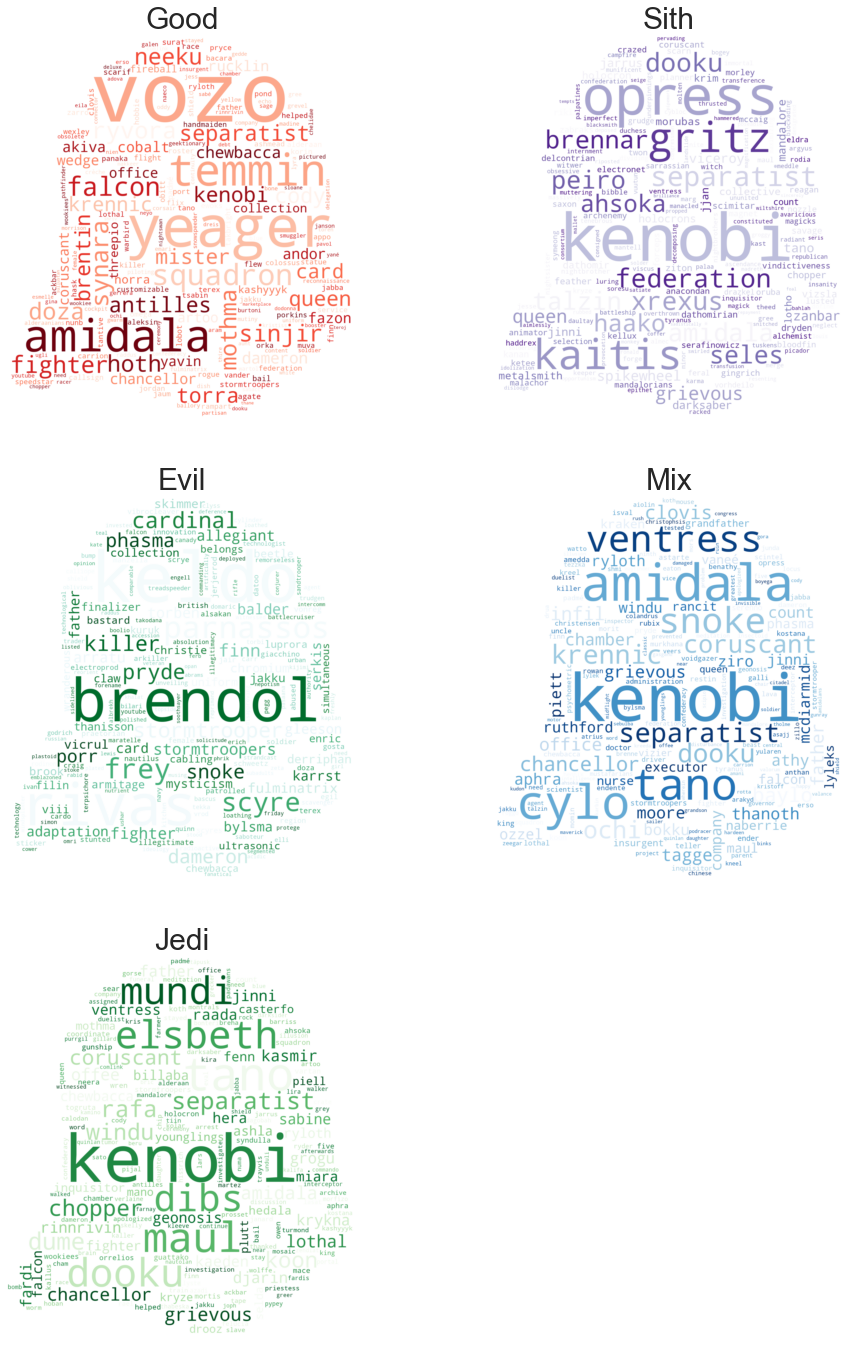

In [37]:
create_wordclouds(corpus_alliance)

As we observe from the evil alliance we can see names from evil characters such as General Hux which was the leader of the First Order. Surprisingly General Kenobi appears on the sith word cloud which is unusual because he is a Jedi, but he had a lot of interactions with Sith lords, thus his appearance on the word cloud is justified. The word "Squadron" appears in the "Good" word cloud, which is the fighting unit of TIE fighters. Finally, for the Jedi word cloud, we can see the characters such as known Jedi [Shaak Ti](https://starwars.fandom.com/wiki/Shaak_Ti) appearing in Jedi word cloud and General Windu but surprisingly we can also see relative names to the Jedis such as [Morgan Elsbeth](https://starwars.fandom.com/wiki/Morgan_Elsbeth) which we found her appearance in the Jedi word cloud surprising after her duels with [Ashoka Tano](https://starwars.fandom.com/wiki/Ahsoka_Tano) and [Mandalorian](https://starwars.fandom.com/wiki/Din_Djarin) on the Star Wars Series "The Mandalorian".

### Part 3.3.2 Word clouds for 5 main characters based on wiki
<a id='word_character_5.'></a>

We find the most important human movie characters based on movie appearance amount.

In [38]:
list_top_5 = [row['File_Name'] for i,row in characters_df.iterrows() if 'Human' in characters_df['Species'][i] if len(re.findall(r'\d',characters_df['Appearance'][i])) >= 7]
list_top_5

['Leia Skywalker Organa Solo',
 'Anakin Skywalker',
 'Luke Skywalker',
 'Darth Sidious',
 'Obi-Wan Kenobi']

As we can observe above the most popular characters. From the light side Leia, Luke, and Obi-wan. From the dark side Darth Sidious, and Anakin Skywalker.

We create a folder on the working directory so we can create a corpus and save the files afterward.

In [39]:
if not os.path.exists('data/top_5'):
    os.makedirs('data/top_5')

We create txt files for the characters we analyze above.

In [40]:
corpus_root_top_5 = os.getcwd() + '/data/top_5/'
file_list_top_5 = pd.Series(list_top_5) + '.txt'
corpus_top_5 = pcr(corpus_root_top_5, file_list_top_5)

We extract the txt file from the character folder for the 5 specific characters, and save them as a new txt files in the new folder we have created above.

In [41]:
for char in list_top_5:
    plus = char + '.txt'
    text = nltk.Text(corpus.words(plus))

    temp_text = [w for w in text]
    temp_string = ' '.join(temp_text)
    
    file_path = corpus_root_top_5 + char + '.txt'
    with open(file_path, 'w', encoding = 'utf-8') as f:
        f.write(temp_string)

Ploting the word clouds.

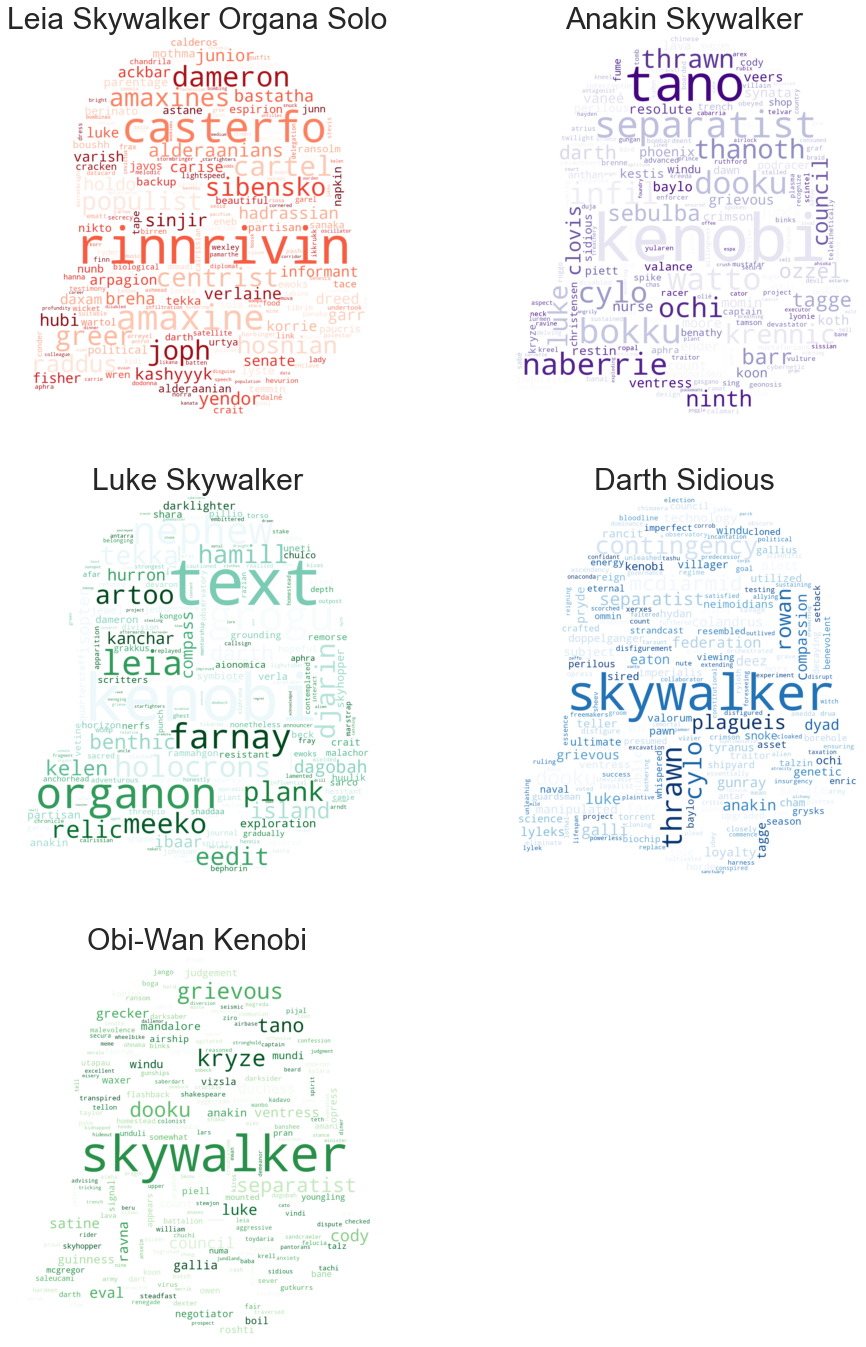

In [42]:
create_wordclouds(corpus_top_5)

The appearance of [Poe dameron](https://starwars.fandom.com/wiki/Poe_Dameron) on Leia's word cloud indicates their friendship on the Sequel Trilogy. In Luke's word cloud we can understand the importance of Jedi 'text' mentioned by Luke and the word [Grogu (Baby Yoda)](https://starwars.fandom.com/wiki/Grogu) that 'Luke' rescues and proceed to train in the Star Wars series "The Mandalorian". Also, the word 'nephew' indicates Kylo Ren (his nephew) one of the main characters of the Sequel Trilogy. For Kenobi's word cloud we can see he has a high connection with 'Ashoka Tano'. That relationship is being explored on the Star Wars series 'The Clone Wars. And for Darth Sidious' word cloud we can see a highly descriptive world of 'Admiral Thrawn' which is a really important character in the Star Wars universe. Lastly, for Anakin we see 'Commander Rex' which was a clone and his colleague for a long time many wars also we can see again 'Ashoka Tano', Anakin's Padawan learner.

### Part 3.3.3 Word clouds for Anakin/Darth Vader based on movies scripts
<a id='word_script.'></a>

To analyse the movie script we need to clean the txt files, this is done using the `clean_text`function which is also used in Part 2.3.

In [45]:
wnl = nltk.WordNetLemmatizer()
def clean_text(text, *args):
    for name in args:
        name = re.sub(r'\(|\)','',name)
        for n in re.split(r'\s',name):
            text = re.sub(n,'',text)

    text = re.sub(r'===.*?===','',text) # removes paterns
    text = re.sub(r'==.*?==','',text) 
    text = re.sub(r'\{\{.*?\}\}','',text)

    tokens = word_tokenize(text) # tokennizing the text
    tokens = [wnl.lemmatize(w.lower()) for w in tokens if (w.lower() not in stopwords.words('english') and w.isalpha())] #changes to lower case and removes unwanted types

    final_words = [word for word in tokens if len(word) > 3] #removing words under length 4
    return final_words

Below we extract and filter the dialogue for Prequel Trilogy (First Trilogy):

In [46]:
def first_trilogy_script(path):
    with open(path, 'r', encoding = 'utf8') as file:
        text = file.read() #Read txt file that contains the dialogue

    #Filtering
    text = re.sub(r'\\\n\\\n','\n\n',text) #some scripts have \ for every new line
    text = re.sub(r'\\\n',' ',text) # same as above
    sw = re.findall(r'(?=.*:).*(?=\n\n)',text) # a dialogue pattern is name: dialogue
    sw = [re.sub(r'\s+',' ',elem) for elem in sw] #substituting multiple whitespace with one

    names = [re.findall('(.*)(?=:)',elem)[0] for elem in sw] # find all the names pattern is name: 
    names = np.unique(names) # only getting unique names
    
    # Create df with names and their dialogues
    sw_df = pd.DataFrame(names,columns=['text'], index = names)
    for _, row in sw_df.iterrows():
        pattern = r'(?<=' + re.escape(row['text']) + r':).*(?=\n\n)' #finding character specific dialogue
        row['text'] = ' '.join(re.findall(pattern,text)) #adding it as a single string

    sw_df['clean_text'] = sw_df['text'].apply(clean_text) #adding a cleaned version 
    
    return sw_df

Loading the script as data frame.

In [47]:
sw1_df = first_trilogy_script('data/script/Star Wars Episode I - The Phantom Menace.txt')
sw2_df = first_trilogy_script('data/script/Star Wars- Episode II - Attack of the Clones.txt')
sw3_df = first_trilogy_script('data/script/Star Wars- Episode III - Revenge of the Sith.txt')

Then we do the same for Star Wars original trilogy. The format for the two trilogies is different, which is why we use two different functions and regex.

In [48]:
# Create function that filters the dialogues
def create_df_SW_OR(path):
    dia = pd.read_csv(path, sep="\t") # the path to find the scripts
    list_char_IV = []
    list_diag_IV = []
    for _, row in dia.iterrows(): # we itterate through one dialogue/line at a time.
        text = row.iloc[0] 
        text_split = text.split('"') # splitting by " to get character and dialogue the format is "character" "dialogue"

        # Add to list the character
        list_char_IV.append(text_split[1]) # 1st element is name

        # Add to daiglog of the character
        list_diag_IV.append(''.join(text_split[3:])) # 3rd element and onwrads is dialogue

    df = pd.DataFrame({'Character': list_char_IV, 'Dialogue': list_diag_IV})
    return df

Initializing the scripts.

In [49]:
star_wars_IV_df = create_df_SW_OR('data/script/SW_EpisodeIV.txt')
star_wars_V_df = create_df_SW_OR('data/script/SW_EpisodeV.txt')
star_wars_VI_df = create_df_SW_OR('data/script/SW_EpisodeVI.txt')

For the word clouds we need dialogue for each character and not chronologically:

In [50]:
# Create dataframe for each character 
def aug_df_SW(df):
    name_unqiue = set(df['Character']) #finding the unique names in our dialogue dataframe
    list_name = []
    list_dia = []
    for i in name_unqiue: 
        list_name.append(i)
        list_dia.append(clean_text(' '.join(df[df['Character'] == i]['Dialogue'].values))) # taking every row equal to the given name
        
    return pd.DataFrame({'Character': list_name, 'Dialogue': list_dia})

Loading the augmented character dialogue data frame.

In [51]:
star_wars_IV_df1 = aug_df_SW(star_wars_IV_df)
star_wars_V_df1 = aug_df_SW(star_wars_V_df)
star_wars_VI_df1 = aug_df_SW(star_wars_VI_df)

We create a dictionary that includes values of words from Anakin's dialogues from the first trilogy. We format it as a dictionary because it is easy to extract and calculate TC-IDF values for word clouds.

In [52]:
anakin_dict = dict(zip(('Star Wars Episode 1', 'Star Wars Episode 2', 'Star Wars Episode 3'),
                   (sw1_df["clean_text"]['ANAKIN'], 
                    sw2_df["clean_text"]['ANAKIN'], 
                    sw3_df["clean_text"]['ANAKIN'])))

Use the [`create_wordclouds`](#wc_function) function we define above and plot the word cloud for Anakin in the prequel trilogy.

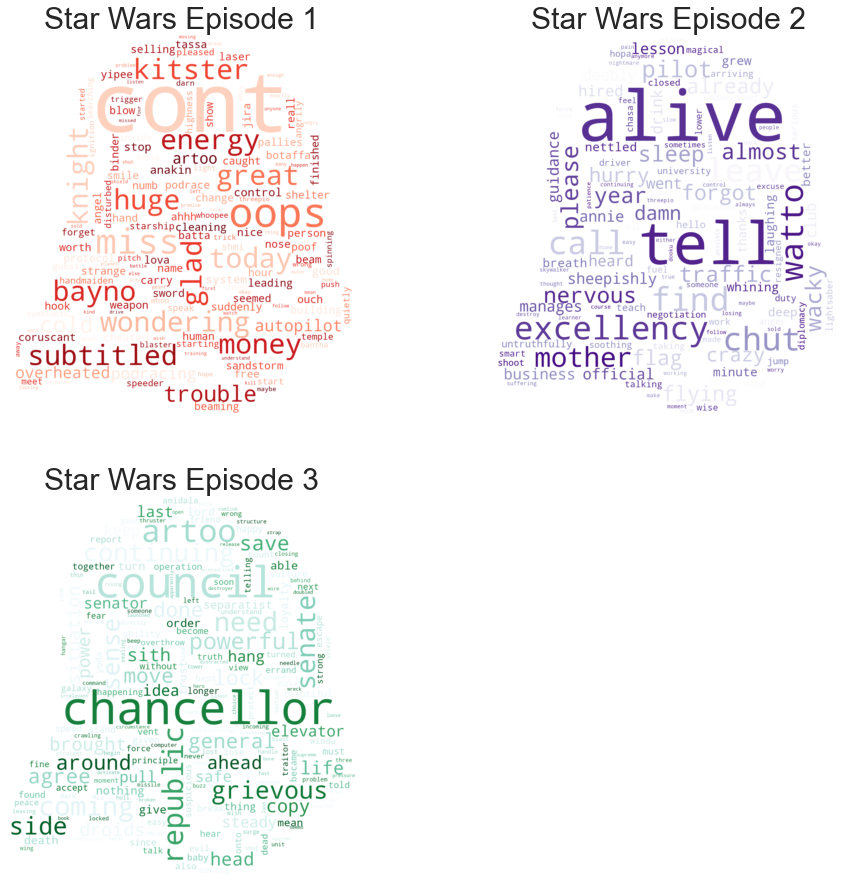

In [53]:
create_wordclouds(anakin_dict)

We see on Anakin's word cloud from the second movie, words that describe his love for Padme such as 'alive' and 'nervous'. The word 'mom' shows us how much he misses his mother in the second movie. Also in the third movie, we can see more political words such as the 'senate', 'Jedi council', 'war', and 'Chancellor' (referring to Chancellor Palpatine).

Creating the dictionary for Anakin (Darth Vader) in the original trilogy.

In [54]:
vader_dict = dict(zip(('Episode 4','Episode 5','Episode 6'),
                   ([word for sublist in star_wars_IV_df1['Dialogue'][star_wars_IV_df1['Character'] == 'VADER'] for word in sublist], 
                    [word for sublist in star_wars_V_df1['Dialogue'][star_wars_V_df1['Character'] == 'VADER'] for word in sublist], 
                    [word for sublist in star_wars_VI_df1['Dialogue'][star_wars_VI_df1['Character'] == 'VADER'] for word in sublist])))

Ploting the word clouds:

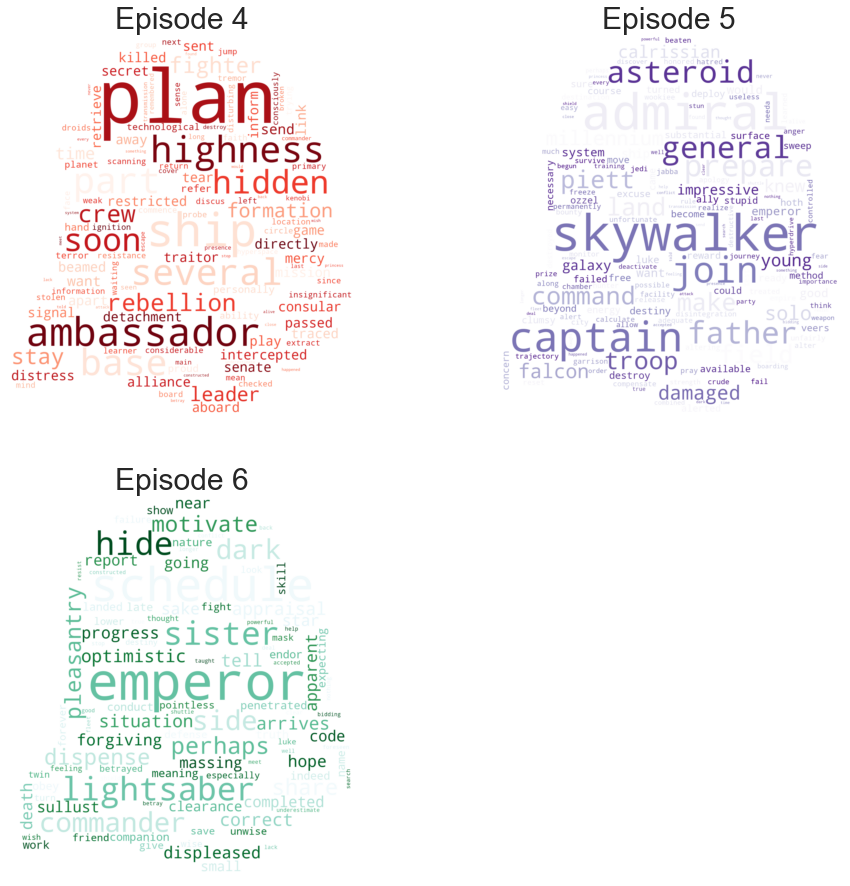

In [55]:
create_wordclouds(vader_dict)

For the sixth movie, we can see important words for the movie plot such as 'emperor', 'lightsaber', 'dark side', and 'sister'. Also in the fifth movie, we observe that the word 'join' appears (from the famous sentence "join the dark side") and the most valuable word for the trilogy is 'father'.

In the next cell, we collect all the words from Anakin's dialogues with the purpose of comparing his dialogues from the prequel trilogy to the original trilogy.

In [56]:
#We create a list of words from Anakin's dialogue from the prequel trilogy
anakin_dialogue = sw1_df['clean_text']['ANAKIN'] + sw2_df['clean_text']['ANAKIN']+ sw3_df['clean_text']['ANAKIN']

#We create a list of words from Anakin's dialogue from the original trilogy
vader_dialogue = star_wars_IV_df1['Dialogue'][star_wars_IV_df1['Character'] == 'VADER'].values[0]\
     + star_wars_V_df1['Dialogue'][star_wars_V_df1['Character'] == 'VADER'].values[0]\
         + star_wars_VI_df1['Dialogue'][star_wars_VI_df1['Character'] == 'VADER'].values[0]

#Above we create a dictionary of both lists from above as values
anakin_vader_dict = {'Anakin Skywalker':anakin_dialogue, 'Darth Vader':vader_dialogue}

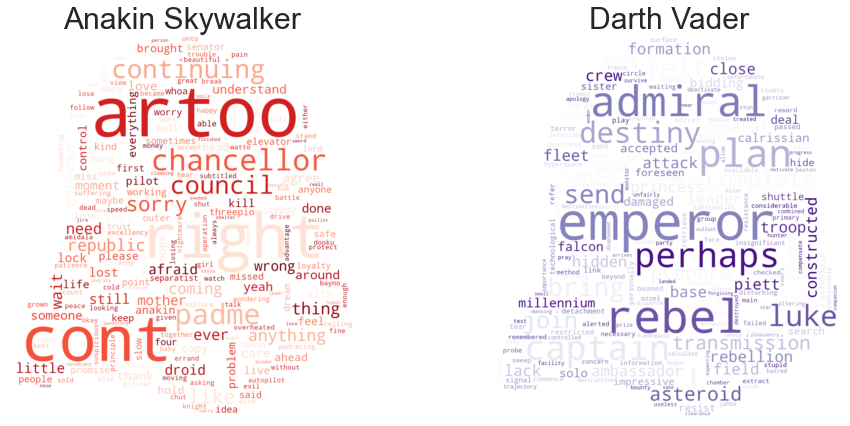

In [57]:
create_wordclouds(anakin_vader_dict)

By comparing Anakin to Darth Vader we can see a lot of descriptive words for example 'Padme' and 'right' which stem from Anakin trying to question if what he does is right. Then words such as 'sorry' and 'mother' create a more emotional thus human aspect to the character, but for Darth Vader's word cloud there are words such as 'emperor', 'destiny', 'rebels fighter', and 'rebellion'. His descriptive words have changed a lot after his transformation to the dark side. Also, the word 'Luke' appears on Darth Vader's word cloud which is his son (spoiler alert).

### Part 3.3.4 Word clouds for the two trilogies based on movies scripts
<a id='word_character.'></a>

We create a dictionary of words based on dialogues from the trilogies.

In [58]:
#We create a list with all the dialogues from Prequel Trilogy
original_dialogue = re.split(' ',' '.join([' '.join(i) for i in sw1_df['clean_text'].values]))\
    + re.split(' ',' '.join([' '.join(i) for i in sw2_df['clean_text'].values]))\
        + re.split(' ',' '.join([' '.join(i) for i in sw3_df['clean_text'].values]))

#We create a list with all the dialogues from Original Trilogy
prequel_dialogue = re.split(' ',' '.join([' '.join(i) for i in star_wars_IV_df1['Dialogue'].values]))\
     + re.split(' ',' '.join([' '.join(i) for i in star_wars_V_df1['Dialogue'].values]))\
         + re.split(' ',' '.join([' '.join(i) for i in star_wars_VI_df1['Dialogue'].values]))

#Dictionary with the lists above as values
original_prequel_dict = {'Original Trilogy':original_dialogue, 'Prequel Trilogy':prequel_dialogue}

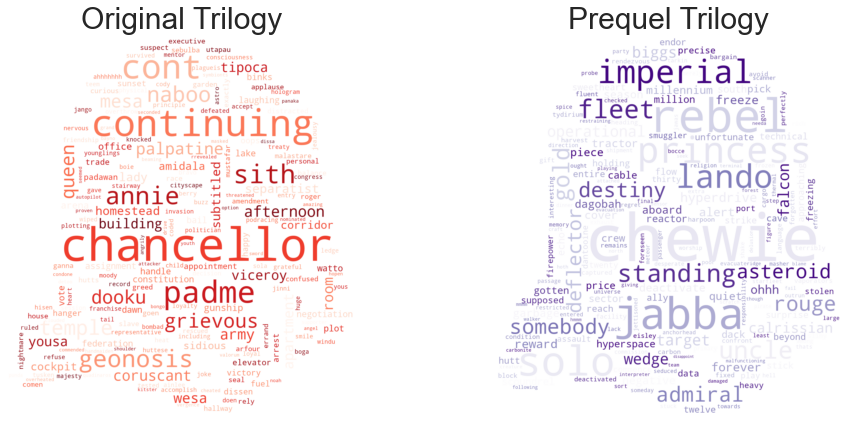

In [59]:
create_wordclouds(original_prequel_dict)

We observe for the first word cloud some descriptive words (of the trilogy plot) such as 'Chancellor', 'Padme', and the battle of 'Geonosis'.
For the Prequel Trilogy, we observe words related to 'Han solo' and Princess 'Leia' such as 'princess', 'solo', 'millennium', 'Calrissian' (Known friend/an allie of Han solo), 'Chewie' (his companion) and 'Jabba the Hut'.

## Part 3.4: Community analysis
<a id='com.'></a> 

We use the partition created in part 2.2.2. 

In [60]:
md(f"The Louvain algorithm found {len(set(partition.values()))} communities for the Star Wars network. The modularity is {community.modularity(partition, G_SW_GCC):.2f}.")

The Louvain algorithm found 18 communities for the Star Wars network. The modularity is 0.48.

The community size is approx 14-19, there is randomness in the Louvain algorithm which is why the community size can differ. To take a closer look at the communities we look a the distribution of community sizes.

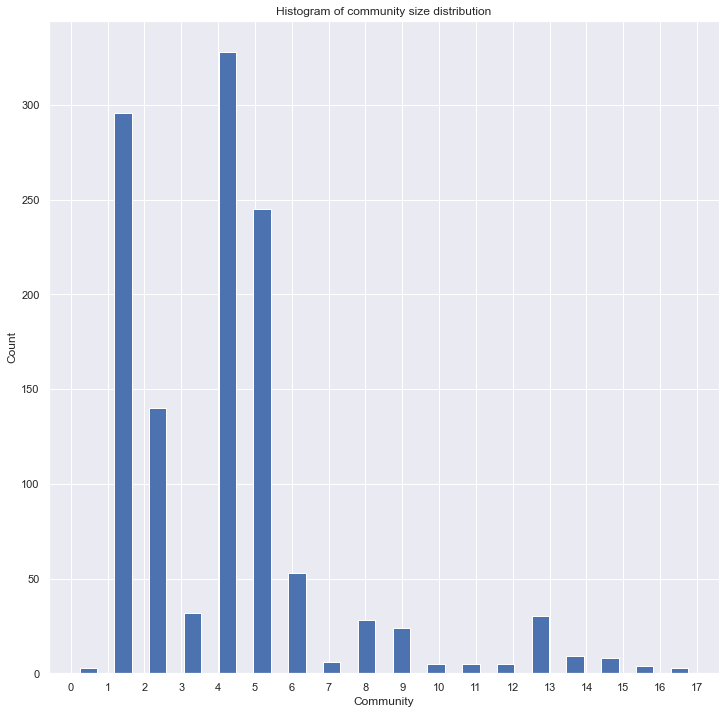

In [61]:
plt.figure(figsize = [12, 12])
freq = plt.hist(partition.values(), bins = len(set(partition.values())), rwidth = 0.5)
community_size = pd.DataFrame(freq[0])
plt.xticks(range(len(set(partition.values()))))
plt.title('Histogram of community size distribution')
plt.xlabel('Community')
plt.ylabel('Count')
plt.show()

From the plot, we see three main communities: 1, 4, and 5, which is also what we saw in our community network plot in part 2.2.2. From the network plot, we saw that these three communities correspond to the three trilogies. To prove this point, we can see to which community the main characters from each trilogy belongs. We'll look at Anakin Skywalker from the first trilogy, Luke Skywalker from the second Trilogy, and Rey Skywalker from the third trilogy.

In [62]:
temp = partition.get('Anakin_Skywalker')
print(f'Anakin Skywalker belongs to community: {temp}')
temp = partition.get('Luke_Skywalker')
print(f'Luke Skywalker belongs to community: {temp}')
temp = partition.get('Rey_Skywalker')
print(f'Rey Skywalker belongs to community: {temp}')

Anakin Skywalker belongs to community: 1
Luke Skywalker belongs to community: 5
Rey Skywalker belongs to community: 4


We see that they belong to the communities we selected above.

The sizes of the communities are:

In [63]:
community_size.rename(columns = {0:'Community Size'}, inplace = True) #renaming column
com_trilogy = pd.DataFrame.from_dict({partition.get('Anakin_Skywalker'): [community_size.iloc[partition.get('Anakin_Skywalker'),0],'pre'], \
    partition.get('Luke_Skywalker'): [community_size.iloc[partition.get('Luke_Skywalker'),0],'or'],\
    partition.get('Rey_Skywalker'): [community_size.iloc[partition.get('Rey_Skywalker'),0],'seq']}, orient='index')
com_trilogy.rename(columns = {0:'Community Size', 1:'Trilogy'}, inplace = True)
com_trilogy

Community Size Trilogy
1           296.0     pre
5           245.0      or
4           328.0     seq

The node count of the GCC is 1224 (Part 3.2.1) and the total node count for these communities is $296+245+328 = 869$, meaning they contain over 50% of all nodes. 

Then we create a dictionary for the three communities, with community number as key and characters as values.

In [64]:
com_dict = dict(zip(list(com_trilogy['Community Size'].keys()), \
    [[key for key, val in partition.items() if val == com]\
     for com in com_trilogy['Community Size'].keys()]))

We want to create a corpus with a txt for the 3 chosen communities. Thus we check/create a Community folder.

In [65]:
if not os.path.exists('data/Communities'):
    os.makedirs('data/Communities')

We create the corpus root and the corresponding file names ('1.txt','5.txt','4.txt').

In [66]:
corpus_root_com = os.getcwd() + '/data/Communities/' # the path
file_list_com = pd.Series([str(key) + '.txt' for key in com_dict.keys()]) # names of the files corrosponding to community number
corpus_com = pcr(corpus_root_com, file_list_com) # the corpus root

The names of the nodes in the graph, which the community is based on, have '\_' in the name, thus we replace it with white space, so it corresponds to the actual character txt names.

In [67]:
for com in com_dict.keys():
    for index in range(len(com_dict[com])):
        for j in characters_df["File_Name"][characters_df['Name'] == str(com_dict[com][index]).replace('_',' ')].tolist():
            com_dict[com][index] = j

Finally, we create one txt file for each of the three communities where we've aggregated the txt files for each of the characters in the community.

In [68]:
for com in com_dict.keys():
    plus = pd.Series(com_dict[com]) + '.txt'
    text = nltk.Text(corpus.words(plus))

    temp_text = [w for w in text]
    temp_string = ' '.join(temp_text)
    
    file_path = corpus_root_com + str(com) + '.txt'
    with open(file_path, 'w', encoding = 'utf-8') as f:
        f.write(temp_string)

The function below returns the top 5 words in a community based on the TF.

In [69]:
def top_5_words_tf(corpus):
    #Dictionary that includes the total number of words on each document
    sum_dict = {d:sum([val for _,val in FreqDist(corpus.words(d)).most_common()]) for d in corpus.fileids()}
    
    #Dictionary with values the term frequency for each word for each document
    tf_dict = {d:{term:(term_count/sum_dict[d]) for term,term_count in FreqDist(corpus.words(d)).most_common()} for d in corpus.fileids()}    

    for community_index in tf_dict.keys():
        top5 = [word for word,_ in sorted(tf_dict[community_index].items(), key=lambda item: item[1],reverse=True)][:5]
        print(f"The top 5 TF words for the community no. {community_index.replace('.txt','')} are {top5}")

The function below returns the top 5 words in a community based on the TF-IDF.

In [70]:
def top_5_words_tf_idf(corpus):
    #Dictionary that includes the total number of words on each document
    sum_dict = {d:sum([val for _,val in FreqDist(corpus.words(d)).most_common()]) for d in corpus.fileids()}
    
    #Dictionary with values the term frequency for each word for each document
    tf_dict = {d:{term:(term_count/sum_dict[d]) for term,term_count in FreqDist(corpus.words(d)).most_common()} for d in corpus.fileids()}    
    
    #Dictionary with inverse document frequency for each unique words
    idf_dict = {}
    for term in set([term for i in tf_dict.keys() for term in tf_dict[i].keys()]):
        N = len(tf_dict.keys())
        nt = 0
        for d in tf_dict.keys():
            if term in tf_dict[d].keys():
                nt += 1
        idf_dict[term] = np.log(N/nt)
    
    #Create TF-IDF dictionary
    tf_idf_dict = {d:{term:tf_dict[d].get(term)*idf_dict.get(term) for term in tf_dict[d].keys()} for d in tf_dict.keys()}

    for community_index in tf_idf_dict.keys():
        top5 = [word for word,_ in sorted(tf_idf_dict[community_index].items(), key=lambda item: item[1],reverse=True)][:5]
        print(f"The top 5 TF-IDF words for the community no. {community_index.replace('.txt','')} are {top5}")

In [71]:
top_5_words_tf(corpus_com)
print('\n')
top_5_words_tf_idf(corpus_com)

The top 5 TF words for the community no. 1 are ['jedi', 'clone', 'vader', 'skywalker', 'force']
The top 5 TF words for the community no. 5 are ['solo', 'first', 'jedi', 'jabba', 'skywalker']
The top 5 TF words for the community no. 4 are ['first', 'order', 'force', 'resistance', 'jedi']


The top 5 TF-IDF words for the community no. 1 are ['cody', 'handmaiden', 'federation', 'clovis', 'ventress']
The top 5 TF-IDF words for the community no. 5 are ['rebo', 'pateesa', 'eisley', 'chainbreaker', 'treasury']
The top 5 TF-IDF words for the community no. 4 are ['doza', 'ryvora', 'torra', 'yeager', 'synara']


Recall that community 1 is the first trilogy, community 5 is the second trilogy, and community 4 is the third trilogy.

Interestingly we see two very different results for TF and TF-IDF.

For TF we see the words we'd expect of a Star Wars movie like 'Jedi', 'skywalker', and 'force'. But these words are very frequent in the Star Wars trilogy, and thus when we apply the IDF, these words are removed, as they are not unique to the trilogies. 

For TF-IDF we see much more trilogy-specific and thus less known words like Cody a clone trooper from movie 3, Rebo a musician from the 6th movie, and Doza a piloted only noted to have been in the 9th movie.

## Part 3.5: Sentiment analysis
<a id='sent.'></a>

We wish to look at sentiment for each of the characters both based on the wiki pages and the scripts. The two methods we will use for sentiment analysis are LabMT and VADER. The LabMT is a dictionary-based approach, which means we will only be able to compute the sentiment for words in the LabMT dataset. This limits the LabMT's ability to deal with connection words such as negation. The VADER method is a combination of a rule-based approach and a dictionary-based approach. The combination means VADER will modify the polarity of a word based on the surrounding words. Due to the rule-based approach the conjunction words, which were ignored in the LabMT method, will also be evaluated. 

VADER is created for social media features for punctuation, emojis, and slang are added.

### Part 3.5.1: Analysis of Wikipage
<a id='S_wiki.'></a>

Wiki pages are normally written in a neutral way. The sentiment analysis is thus not suited for wiki pages but for the fun of it, let's try and see what will get out of it.

For sentiment analysis, we will be using LabMT and VADER. Thus, we need to get these two methods ready. First, we load the txt file for the LabMT methods and initialize VADER.

In [72]:
# Load the LabMT data and convert to dictionary
LabMT_df = pd.read_csv('data/labMT.txt', sep="\t", header=0, skiprows=[0,1])
word_list_LabMT = LabMT_df['word'].tolist()
LabMT_dict = LabMT_df.set_index('word')['happiness_average'].to_dict()

# VADER form the vaderSentiment library
analyzer = SentimentIntensityAnalyzer()

## Load the wiki page for each character and save in a dictionary 
wiki = {}

We will save the characters and their corresponding wiki page inside a dictionary. To do this we will loop over all characters and extract the text from [WOOKIEEPEDIA](https://starwars.fandom.com/wiki/Main_Page).

In [73]:
# Define the names for loading URL
characters_df['url_Name'] = characters_df['Name'].str.replace("/","_")
all_txt = characters_df['url_Name'].str.replace(' ', '_').to_numpy()

# Save find the characters with empty wiki pages 
emp_char = []

# Initialzation for loading the URL 
baseurl = "https://starwars.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat = "format=json"

# Loop over all character and extract the wiki page 
for name in all_txt:

    # Create empty dictrionary for the character name
    wiki[name] = {}
    
    # Load the wikipages
    title = "titles=" + name
    queryChar = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    temp = ''.join(chr(ord(c)) for c in urllib.parse.quote(queryChar))
    temp = np.char.replace(temp, '%3A', ':')
    temp = np.char.replace(temp, '%3F', '?')
    temp = np.char.replace(temp, '%3D', '=')
    queryChar = str(np.char.replace(temp, '%26', '&'))

    # Open and load the wikipage 
    response = urllib2.urlopen(queryChar) # Load wiki
    wiki_char = json.load(response)

    # Extract the text inside the wikipage 
    page_id = list(wiki_char['query']['pages'].keys())[0]
    text_temp = wiki_char['query']['pages'][page_id].get('extract',None)

    # Finding the workcout of wikipage and adding it to the dictionary
    if text_temp:
      lines = text_temp
      pattern = re.compile(r'\w+')
      wiki[name]['word_count'] = len(pattern.findall(lines))
    else: 
      print(f'No wiki page found for {name}')
      emp_char.append(name)
      lines = ''
      wiki[name]['word_count'] = 0

    # Saving the wiki pages inside the dictionary
    wiki[name]['wiki'] = lines

No wiki page found for LEP_servant_droid
No wiki page found for CT-0000_1010
No wiki page found for CT-55_11-9009
No wiki page found for Pamich_Nerro_Goode
No wiki page found for Canid


We see that some of the characters we were not able to obtain the wiki page. After inspecting the name and the wiki page we found the reason being there exists a '_/_' on the wiki page, since it is only 5 characters and all are minor characters we'll let it pass.

Secondly, we will create functions to compute the average sentiment for each character's wiki page using LabMT and VADER. Functions `compute_avg_sentiment_LabMT` and `compute_avg_sentiment_VADER` are defined, they will compute the sentiment score for the given text file. We will start with the `compute_avg_sentiment_LabMT` since the LabMT is a dictionary-based approach we will only be able to calculate a sentiment score for a word if the word is inside the LabMT dataset. We will start with cleaning the text and tokenizing it. Then by using the `FreqDist` function, we will be able to only compute the score for all unique words inside the text file once.

In [74]:
# Define function for compute LabMT sentiment for a text
def compute_avg_sentiment_LabMT(text):
    # Join all sentences to one string

    # Clean text 
    words_final = clean_text(text)
    
    # Initialization to store values
    s = 0
    n = 0

    # Using freqDist to only loop over unique words 
    fdist = FreqDist(w for w in words_final)
    word_unique = [word for word in fdist.keys()]
    word_fre = [f for f in fdist.values()]

    # Loop over words 
    for i in range(len(fdist)):
        w = word_unique[i]
        f = word_fre[i]

        # Get the LabMT score
        S_v = LabMT_dict.get(w, None)

        # Weight the socre by the frequency
        if S_v is not None:
            s += f * LabMT_dict.get(w, None)
            n += f
            
    if n == 0:
        return np.nan
    return s/n

The second function we will define is the `compute_avg_sentiment_VADER`, which is the VADER method. This method has a rule-based approach and thus it can take a sentence without needing to clean it and tokenize it.

In [75]:
# Define function for compute sentiment for a text
def compute_avg_sentiment_VADER(text):
    if len(text) == 0:
        return 0
    
    # Convert the text file to the right format, where each line is a  new element
    text = text.split('\n')
    if len(text) == 1:
        text = [text, '']

    # Initialzation 
    s = 0
    len_VADER = 0

    # Compute polarity for each sentence in text 
    for sentence in text:
        if sentence:
            vs = analyzer.polarity_scores(sentence)
            s += vs['compound']
            len_VADER += 1
            
    # Retur the average polarity
    return s/len_VADER

Now we will compute the average sentiment for each character and save it in dictionaries. 

In [76]:
## Loop through all 
dict_LabMT = {}
dict_VADER = {}
for key in wiki:
    LabMT_v = compute_avg_sentiment_LabMT(wiki[key]['wiki'])
    VADER_v = compute_avg_sentiment_VADER(wiki[key]['wiki'])
    dict_LabMT[key] = LabMT_v
    dict_VADER[key] = VADER_v
    wiki[key]['LabMT'] = LabMT_v
    wiki[key]['VADER'] = VADER_v

In [97]:
# saving the data above as pickle
with open('data/wiki.pickle', 'wb') as handle:
    pickle.dump(wiki, handle, protocol=pickle.HIGHEST_PROTOCOL)

Visualizations for the distribution of the sentiment using LabMT and VADER are created. 

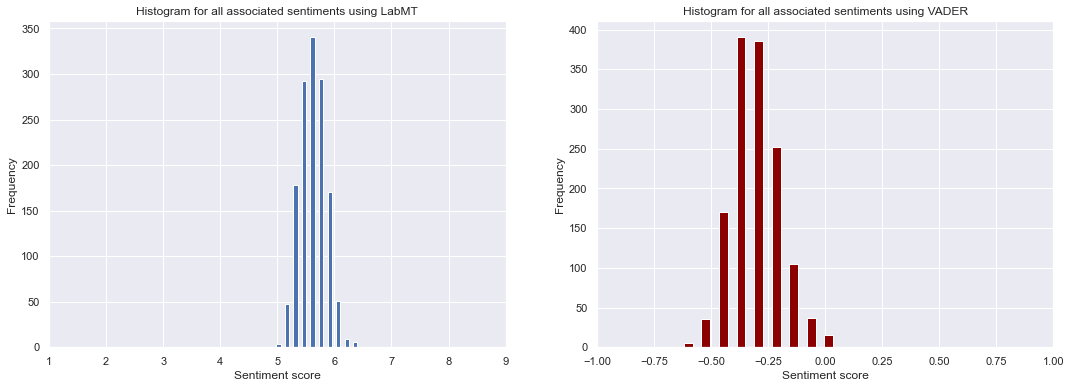

In [77]:
figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(dict_LabMT.values(), bins=10, align='left', rwidth = 0.5)
plt.title('Histogram for all associated sentiments using LabMT')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([1,9])

plt.subplot(1,2,2)
plt.hist(dict_VADER.values(), bins=10, align='left', rwidth = 0.5, color='darkred')
plt.title('Histogram for all associated sentiments using VADER')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([-1,1])

plt.show()

The plot above shows the distribution of sentiment for all characters using two different methods. It is important to note, that the scale and mean are defined differently for the two methods. 

On the left-hand side, we see the results from LabMT. The average for this method is 5 and we can see that the majority of the characters are slightly above average. But the values are close to 5 which means they will still be categorized as neutral. On the right-hand side, we have the distribution created by the VADER method. Here we see that the mean is zero and the vast majority are below 0. Furthermore, we see that some will be classified as negative since they have a score lower than -0.5. 

As we can see the two methods results in very different results. This is due to the different approaches these two methods use. The VADER uses a combination of the rule-based and dictionary-based approach which means more aspects are picked up from text files, such as negation and conjunctions. Furthermore, we see that the VADER shows, that there are characters who will be categorized as negative. A reason for the sentiment analysis score being low could be because the Star Wars movies are talking about war with a lot of weapons and describing evil and good. Since most of the words related to war are categorized as negative this explains why the sentiment is tilted towards negative.

The VADER method categorized some characters not as neutral, we will take a closer look at these characters. 

In [78]:
# Sort the dictionary based on VADER score 
sorted_VADER = dict(sorted(dict_VADER.items(), key=lambda item: item[1]))

# Print the top 5 most negative characters 
for i in range(5):
    print(f"{list(sorted_VADER.keys())[i]} has VADER sentiment vlues of {np.round(list(sorted_VADER.values())[i],2)}")

Grievous has VADER sentiment vlues of -0.6
Mot-Not_Rab has VADER sentiment vlues of -0.56
Edcel_Bar_Gane has VADER sentiment vlues of -0.55
Po_Nudo has VADER sentiment vlues of -0.53
IG-101 has VADER sentiment vlues of -0.53


The top 5 most negative characters from the VADER methods are all categorized as having a negative sentiment. The most negative character is Grievous who was a warlord. He has a detailed wiki page describing all the things he has done, which are all war-related. For the rest of the top 5 most negative characters, by inspecting their corresponding wiki page we see that the wiki pages are short. This could result in the sentiment being lower since all Star Wars characters most likely have war-related words, thus when the wiki page is short these will weigh more.

### Part 3.5.2: Analysis of Movie Scipts
<a id='S_script.'></a>

### Loading the scripts
The wiki pages are written in a neutral way, thus we found that it may be more interesting to take a look at the movie scripts. We wish to examine if we can find time in movies, where characters are more happy or sad. We start with loading the scripts. As mentioned earlier the scripts for the original trilogy and the prequel trilogy are different, thus we need to define two different functions to create a data frame for all dialogues appearing in chronological order. First, we will define the function `create_df_SW_OR` which creates the data frame based on the txt file from [github](https://github.com/kamran786/Star-Wars-Movie-Scripts-Text-Analysis).

In [79]:
# Define function to load script of the original trilogy 
def create_df_SW_OR(path):

    # Load txt file
    dia = pd.read_csv(path, sep="\t")

    # Initilaize list for the character and dialouge 
    list_char_IV = []
    list_diag_IV = []

    # Loop over all rows in data 
    for _, row in dia.iterrows():
        text = row.iloc[0]
        text_split = text.split('"')

        # Add character speaking to list
        list_char_IV.append(text_split[1])

        # Add daiglog to list
        list_diag_IV.append(''.join(text_split[3:]))

    # Create dataframe 
    df = pd.DataFrame({'Character': list_char_IV, 'Dialogue': list_diag_IV})
    df['Sentiment_LabMT'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_LabMT(x))
    df['Sentiment_VADER'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_VADER(x))
    return df

Now we will define the function `create_df_SW_PREQUAL` for creating the dataframes for the prequal movies based on the text files created from [script_I](https://www.actorpoint.com/movie-scripts/scripts/star-wars-the-phantom-menace.html), [script_II](http://sellascript.com/Source/resources/screenplays/attackoftheclones.htm), and [script_III](https://www.actorpoint.com/movie-scripts/scripts/star-wars-revenge-of-the-sith.html).

In [80]:
def create_df_SW_PREQUAL(path):

    # Open file 
    with open(path, 'r', encoding = 'utf8') as file:
        text = file.read()
    
    # remove newlines 
    text = re.sub(r'\\\n\\\n','\n\n',text)
    text = re.sub(r'\\\n',' ',text)
    text = re.sub(r'\(.*\)', '', text)

    # Finding the correct format for the dialogues
    sw1 = re.findall(r'(?=.*:).*(?=\n\n)',text)
    sw1 = [re.sub(r'\s+',' ',elem) for elem in sw1]

    # Loop through all dialogues and add the speaking character and dialogue
    list_char = []
    list_dia = []
    for row in sw1:
        split_text = row.split(':')
        list_char.append(split_text[0])
        list_dia.append(' '.join(split_text[1:]))
    
    # Create dataframe and compute sentiment 
    df = pd.DataFrame({'Character' : list_char, 'Dialogue' : list_dia})
    df['Sentiment_LabMT'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_LabMT(x))
    df['Sentiment_VADER'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_VADER(x))

    return df

We will now create a data frame for each movie. 

In [81]:
# Load the script for the original trilogy
star_wars_IV_df = create_df_SW_OR('data/script/SW_EpisodeIV.txt')
star_wars_V_df = create_df_SW_OR('data/script/SW_EpisodeV.txt')
star_wars_VI_df = create_df_SW_OR('data/script/SW_EpisodeVI.txt')

# Load the scripts for the prequals 
star_wars_I_df = create_df_SW_PREQUAL('data/script/Star Wars Episode I - The Phantom Menace.txt')
star_wars_II_df = create_df_SW_PREQUAL('data/script/Star Wars- Episode II - Attack of the Clones.txt')
star_wars_III_df = create_df_SW_PREQUAL('data/script/Star Wars- Episode III - Revenge of the Sith.txt')

The scripts are loaded where the _index_ is dialogue number in the movie, _Character_ is the character who is saying the dialogue, and _Dialogue_ is the dialogue itself. We Can see an example below from the fifth movie.

In [82]:
star_wars_V_df.head()

Character                                           Dialogue  \
0      LUKE  Echo Three to Echo Seven. Han, old buddy, do y...   
1       HAN                    Loud and clear, kid. What's up?   
2      LUKE  Well, I finished my circle. I don't pick up an...   
3       HAN  There isn't enough life on this ice cube to fi...   
4      LUKE  Right. I'll see you shortly. There's a meteori...   

   Sentiment_LabMT  Sentiment_VADER  
0         6.103333           0.0000  
1         5.320000           0.3818  
2         6.456667           0.2732  
3         5.732500           0.0000  
4         5.602500           0.0772

For different comparisons, we will merge data frames together to create one data frame for all movies and create indications of where the movie changes.

In [83]:
# Create dataframe for all movies 
SW_script_df = pd.concat([star_wars_I_df, star_wars_II_df, star_wars_III_df, star_wars_IV_df, star_wars_V_df, star_wars_VI_df]).reset_index()

## Saving index for where the movies shift for later plot
index_II = len(star_wars_I_df)
index_III = index_II + len(star_wars_II_df) 
index_IV = index_III + len(star_wars_III_df) 
index_V = index_IV +  len(star_wars_VI_df) 
index_VI = index_V + len(star_wars_V_df) 
index_All = [0, index_II, index_III, index_IV, index_V, index_VI]
movies_index =['SW_I', 'SW_II', 'SW_III', 'SW_IV', 'SW_V', 'SW_VI']
color_movie = [ 'hotpink', 'darkorchid', 'indigo', 'green', 'darkgreen', 'olive']

#### Initial overview
Now we have all the data ready. We will start by creating some simple plots to get an initial overview of the sentiment scores for the dialogues throughout all the movies.

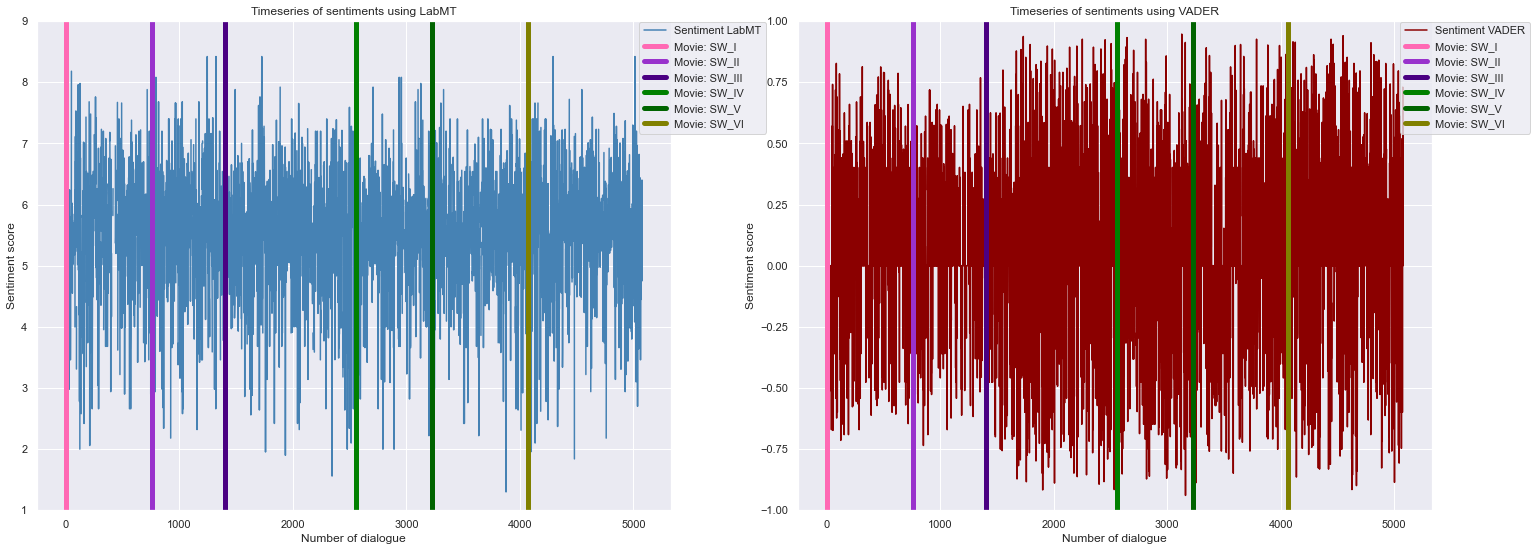

In [84]:
# Plot sentiment as timeseries
figure(figsize = (25,9))
ax = plt.subplot(1,2,1)
plt.plot(SW_script_df.index, SW_script_df['Sentiment_LabMT'], label = 'Sentiment LabMT', color='steelblue')
plt.ylim([1,9])
plt.ylabel('Sentiment score')
plt.xlabel('Number of dialogue')
plt.title('Timeseries of sentiments using LabMT')
# Add the movie indications 
for i,j,c in zip(index_All, movies_index, color_movie):
    plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
plt.legend(loc=(0.95,0.77))


ax2 = plt.subplot(1,2,2)
plt.plot(SW_script_df.index, SW_script_df['Sentiment_VADER'], color='darkred', label = 'Sentiment VADER')
plt.ylim([-1,1])
plt.ylabel('Sentiment score')
plt.xlabel('Number of dialogue')
plt.title('Timeseries of sentiments using VADER')
# Add the movie indications 
for i,j,c in zip(index_All, movies_index, color_movie):
    plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
plt.legend(loc=(0.95,0.77))

plt.show()

We have plotted the sentiment scores as a time series based on when the dialogue appears in all the movies. This plot is created in chronological order meaning the prequel movies come before the original movies. From the plot, we see that the sentiment varies a lot. We cannot see any clear indications of a large period of time where characters are happy or sad.

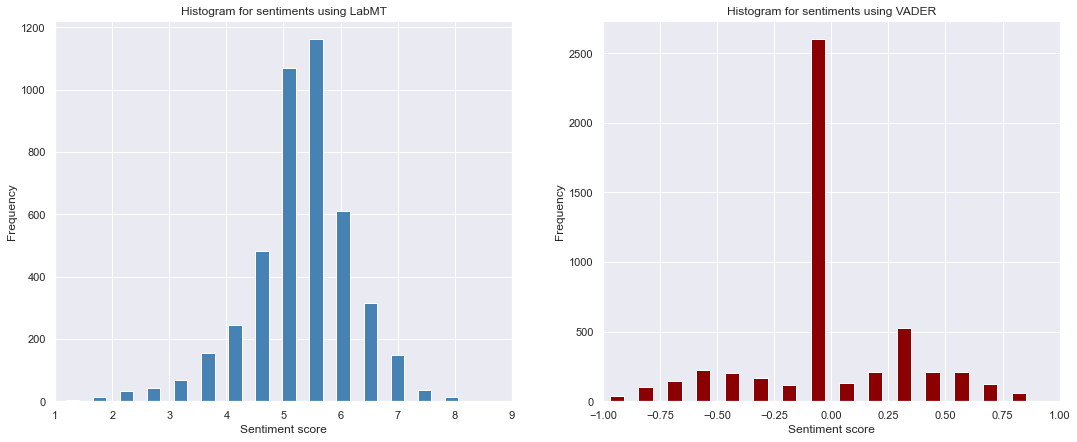

In [85]:
# Plot distirubtion of sentiment 
figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.hist(SW_script_df['Sentiment_LabMT'], bins=15, align='left', rwidth = 0.5, color='steelblue')
plt.title('Histogram for sentiments using LabMT')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([1,9])

plt.subplot(1,2,2)
plt.hist(SW_script_df['Sentiment_VADER'], bins=15, align='left', rwidth = 0.5, color='darkred')
plt.title('Histogram for sentiments using VADER')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([-1,1])

plt.show()

Above we have the distribution plot for the sentiment using the two methods. We see that for both methods we have scored across the whole range, but for both methods majority of the dialogues are categorized as neutral.

#### Character based analysis
We will take a look at the average sentiment for characters with the highest amount of dialogue. 

In [86]:
SW_script_df.groupby('Character').agg({'Dialogue': 'count', 'Sentiment_LabMT':'mean', 'Sentiment_VADER':'mean'})\
    .sort_values('Dialogue', ascending=False).head(10)

Dialogue  Sentiment_LabMT  Sentiment_VADER
Character                                            
ANAKIN          595         5.487858         0.045117
LUKE            494         5.600957         0.056700
HAN             459         5.656073         0.106785
OBI-WAN         406         5.473702         0.022823
THREEPIO        306         5.477057         0.056952
PADME           266         5.642045         0.045704
LEIA            227         5.550765         0.045899
YODA            148         5.436529         0.030401
QUI-GON         142         5.609359         0.056849
VADER           140         5.446784         0.033340

We can see the top 10 characters with most dialogues for both methods have an average sentiment of around 5 and 0 respectively to LabMT and VADER, which are categorized as neutral.

To take a detailed look into characters' time series plot for sentiment, we will start with defining the function for plotting the time series based on a given character. 

In [87]:
def time_sentiment(df, name_list):
    figure(figsize = (25,9))
    plt.subplot(1,2,1)

    # Plot for LabMT
    sns.set_palette("Set1")
    for name in name_list:
        df_temp = df[df['Character'] == name]
        plt.plot(df_temp.index, df_temp['Sentiment_LabMT'], label = name)
    # Add the movie indications 
    for i,j,c in zip(index_All, movies_index, color_movie):
        plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
    plt.legend(loc=(0.95,0.77))
    plt.ylabel('Sentiment score')
    plt.xlabel('Number of dialogue')
    plt.ylim([1,9])
    plt.title('Timeseries of sentiments for' + str(name_list) + 'using LabMT')

    plt.subplot(1,2,2)
    # Plot for VADER
    sns.set_palette("Set2")
    for name in name_list:
        df_temp = df[df['Character'] == name]
        plt.plot(df_temp.index, df_temp['Sentiment_VADER'], label = name)
    # Add the movie indications 
    for i,j,c in zip(index_All, movies_index, color_movie):
        plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
    plt.legend(loc=(0.95,0.77))
    plt.ylim([-1,1])
    plt.ylabel('Sentiment score')
    plt.xlabel('Number of dialogue')
    plt.title('Timeseries of sentiments for ' + str(name_list) + ' using VADER')

    plt.show()

From the word cloud, we found that Anakin Skywalker (Darth Vader) had an interesting shift in the type of word occurring based on the movies. We will see if we can see a similar tendency in the sentiment based on the dialogues spoken by him. Additionally, as previously mentioned he shifts from the light side to the dark side, thus we wish to see if this can be seen in the sentiment. 

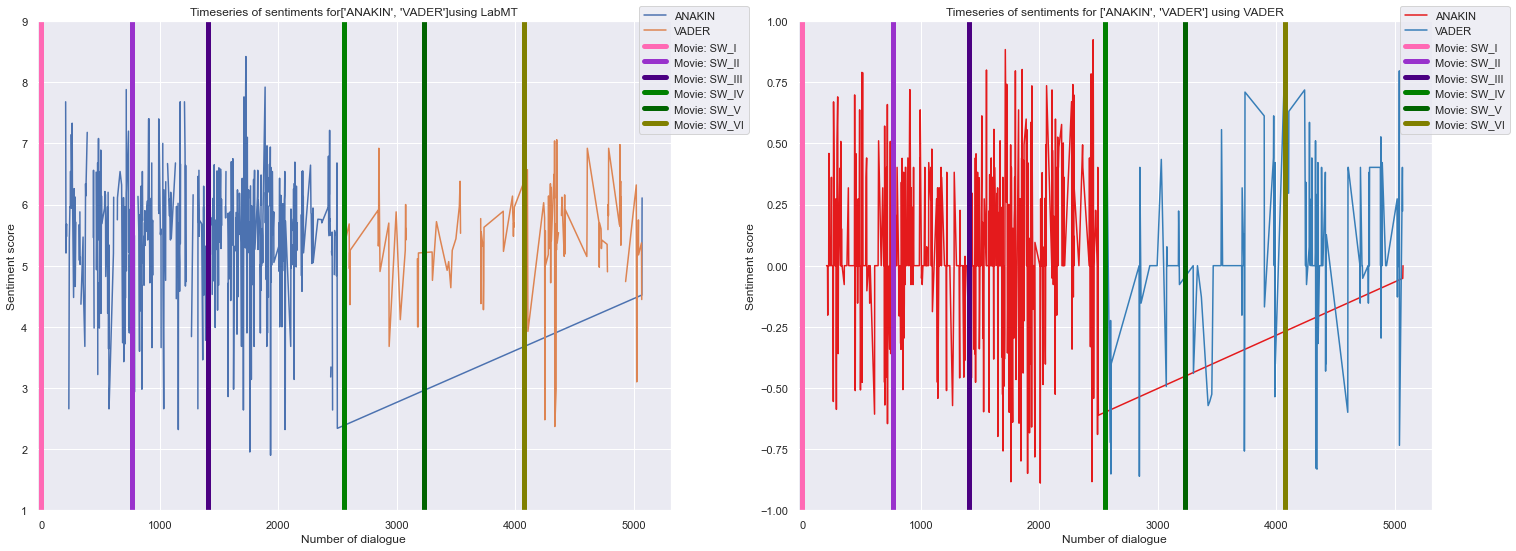

In [88]:
time_sentiment(SW_script_df, ['ANAKIN','VADER'])

From the plot above we see on the left-hand side, that there is no clear tendency to use LabMT. For the VADER plot on the right, we see that in the second movie Anakin in the beginning primarily has a more positive sentiment. From the world clouds in section 4.2 positive words occurs such as 'alive' and 'laughing'. We know from the movies that he is in love at that time. 

But from the plot, we also see a tendency towards positive in the second half of the third movie. From watching the movie, we know that this is where he is questioning himself and turning to the dark side. This contradicts with the sentiment since you would imagine someone in the question of his existence will not use a lot of words that are positive. This could also mean that the reason for the positive tendency in the second movie could be a coincidence. 

We will look at Yoda's sentiment time series plot to see if the sentiment also varies.

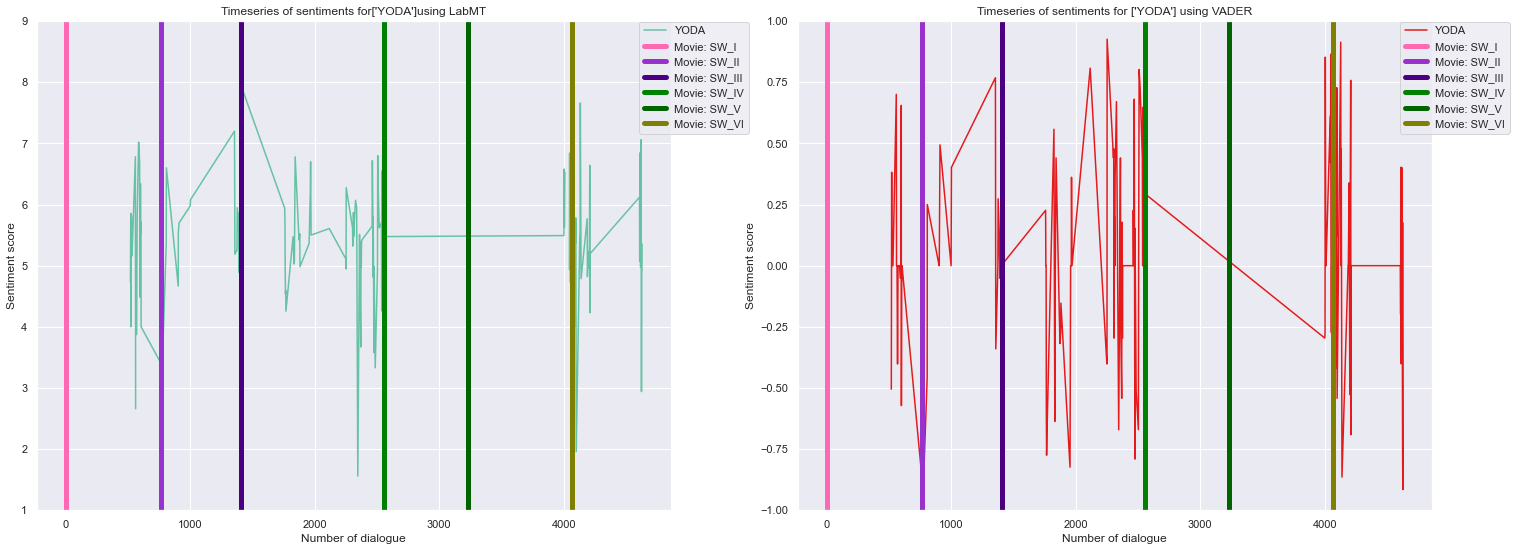

In [89]:
time_sentiment(SW_script_df, ['YODA'])

From the plot for Yoda, we again see that there is a lot of variation in the tendency which is unexpected since Yoda is supposed to be a wise character. Additionally, as a Jedi, you are supposed to be neutral. These traits can not be seen in the plot.  

From the sentiment analysis, we found that the sentiment for the dialogues varies a lot. The sentiment analysis on the Star Wars scripts is not informative. We cannot see any overall tendency for the movies or characters based on the scripts. One of the reasons for this conclusion could be that the scripts are only part of a movie. How an actor acts out the dialogue will largely affect how the viewer perceives the emotions. If a character cries while saying 'I am happy' in the sentiment analysis will categorize it as being positive, but in reality, the actor and the screen are trying to express a sad emotion. The movie scripts are only a small part of expressing the emotions of characters, and thus if we wish to analyze the emotions characters are expressing, we need to take more into account than solely the dialogues.

## Part 3.6: Hidden topic modeling
<a id='htm.'></a> 

Here we'll apply hidden topic modeling to two different corpora and see how the topics are related to the documents.

We'll use the Latent Dirichlet Allocation (LDA) model which is an unsupervised machine learning model, thus no previous labeling has to be made, and we only have to provide our corpus.

### Part 3.6.1: Movie Scipts
<a id='htm_script.'></a> 

For this part we'll use the txt files generated in Part 3.3.3

We examine if the hidden topic modeling can detect 6 different topics (hidden topics = 6) for the 6 different movies. 

Thus we initialize by creating a corpus of the scripts for every movie. We reuse the data frames for the scripts defined in previous parts.

In [90]:
list_of_scripts = [re.split(' ',' '.join([' '.join(i) for i in sw1_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in sw2_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in sw3_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_IV_df1['Dialogue'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_V_df1['Dialogue'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_VI_df1['Dialogue'].values]))]

With this we just need to build a dictionary with `corpora.Dictionary` which we can then use to map it to an index accordingly with `id2word.doc2bow`

In [100]:
id2word = corpora.Dictionary(list_of_scripts) # creating dictionary

common_corpus = [id2word.doc2bow(index) for index in list_of_scripts] # maping to index

model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 6, chunksize = 1, random_state = 3) #building model
model.show_topics(num_topics=6, num_words = 8) # printing out the words for the topics

[(0,
  '0.006*"jedi" + 0.005*"master" + 0.004*"anakin" + 0.003*"know" + 0.003*"must" + 0.003*"council" + 0.003*"going" + 0.003*"right"'),
 (1,
  '0.018*"luke" + 0.013*"come" + 0.012*"know" + 0.011*"going" + 0.011*"right" + 0.010*"artoo" + 0.009*"take" + 0.008*"good"'),
 (2,
  '0.025*"chewie" + 0.011*"jabba" + 0.011*"solo" + 0.008*"rebel" + 0.007*"princess" + 0.006*"right" + 0.006*"imperial" + 0.006*"going"'),
 (3,
  '0.004*"jedi" + 0.004*"right" + 0.003*"going" + 0.003*"anakin" + 0.003*"master" + 0.003*"know" + 0.003*"ship" + 0.003*"think"'),
 (4,
  '0.020*"father" + 0.012*"know" + 0.012*"master" + 0.012*"right" + 0.012*"dark" + 0.011*"jedi" + 0.011*"well" + 0.010*"artoo"'),
 (5,
  '0.003*"right" + 0.003*"know" + 0.003*"master" + 0.003*"going" + 0.003*"jedi" + 0.003*"think" + 0.002*"look" + 0.002*"rebel"')]

With this topic modeling, we see some clear topic-movie correlation. For topic 0 we have 'princess' and 'uncle' which are specific to the 4th movie. For topic 4 we see 'father' and 'sister' which is also specific to movie 6. But there are also problems, looking at topic 3 Luke and Anakin are only mentioned together in the 6th movie, but we already assigned topic 4 to movie 6. Additionally, the words have a small weight and are thus not descriptive of the topic. 

When mapping the topics with PCA we also see this problem:

In [101]:
temp = pyLDAvis.gensim_models.prepare(topic_model=model, corpus=common_corpus, dictionary=id2word)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pyLDAvis.enable_notebook()
pyLDAvis.display(temp)

Here topic 5 (in the plot) corresponds to topic 0 (in our model print), and we see that this topic is negligible in size. Topic 1 (plot) corresponds to topic 5 (print output) and given its large size and the fact that it contains words like (Luke, Vader, Emporer, Leia, Force, etc.) it most likely describes the entire original trilogy (movies 4-6). 

The fact that LDA does not capture all 6 movies and just the general themes is likely due to two reasons. 
1) It's an unsupervised model and thus the result will differ every time, which is why we set the random_state. This also means it's probably possible to create 6 clearly different topics for the 6 movies, but statistically, it will be unlikely because

2) the movies are very similar. They are all from the same cinematic universe and movies 4 and 6 had the same plot of destroying the death star. Additionally, the main characters are the same in the sequel, and in the prequels.

This is why we'll also look at choosing 2 hidden topics instead (one for each trilogy):

In [93]:
model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 2, chunksize = 1, random_state = 5) #building model
model.show_topics(num_topics=2, num_words = 8) # printing out the words for the topics

[(0,
  '0.011*"jedi" + 0.010*"master" + 0.010*"right" + 0.010*"father" + 0.010*"know" + 0.008*"good" + 0.008*"well" + 0.007*"going"'),
 (1,
  '0.014*"luke" + 0.010*"come" + 0.009*"know" + 0.009*"going" + 0.008*"right" + 0.008*"artoo" + 0.007*"take" + 0.007*"back"')]

'Luke', 'father', and 'Chewie' are from the sequels, thus the hidden topic modeling is still not capturing prequels/sequels. 

Finally, we'll do a hidden topic analysis for each movie separately:

In [94]:
i = 1

for movie in list_of_scripts:
    id2word = corpora.Dictionary([movie]) # creating dictionary

    common_corpus = [id2word.doc2bow(index) for index in [movie]] # maping to index

    model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 1) #building model
    print(f'Movie: {i}')
    print(f'{model.show_topics(num_topics=1, num_words = 6)}\n') # printing out the words for the topics
    i += 1

Movie: 1
[(0, '0.019*"cont" + 0.008*"think" + 0.008*"master" + 0.007*"know" + 0.007*"take" + 0.007*"mesa"')]

Movie: 2
[(0, '0.016*"master" + 0.016*"geonosis" + 0.014*"jedi" + 0.010*"night" + 0.010*"anakin" + 0.009*"naboo"')]

Movie: 3
[(0, '0.018*"jedi" + 0.016*"anakin" + 0.012*"master" + 0.011*"continuing" + 0.010*"chancellor" + 0.010*"know"')]

Movie: 4
[(0, '0.012*"going" + 0.011*"luke" + 0.009*"right" + 0.009*"come" + 0.007*"know" + 0.007*"ship"')]

Movie: 5
[(0, '0.010*"know" + 0.009*"right" + 0.009*"going" + 0.008*"good" + 0.008*"well" + 0.007*"come"')]

Movie: 6
[(0, '0.012*"luke" + 0.009*"artoo" + 0.009*"come" + 0.009*"father" + 0.008*"chewie" + 0.008*"master"')]



Unsurprisingly the topic modeling better captures the plot of the movies. Geonosis is a planet important to the second movie, and 'Mesa' Jar-Jar's catchphrase from the first movie. However, we still see the topics for movies 1 and 5 are undescriptive given their low word score.

### Part 3.6.2: Communities
<a id='htm_com.'></a> 

First, we generate the list of lists for the 3 communities where we can reuse the dictionary created in Part 3.4. Recall that the 3 communities also correspond with the 3 trilogies.

In [95]:
com_top = [corpus_com.words(c) for c in corpus_com.fileids()]

In [96]:
id2word = corpora.Dictionary(com_top)

common_corpus = [id2word.doc2bow(index) for index in com_top]

model = gensim.models.LdaMulticore(corpus = common_corpus, id2word = id2word, num_topics = 3)
cm = CoherenceModel(model=model, corpus=common_corpus, coherence='u_mass')
coherence = cm.get_coherence()

model.show_topics(num_topics=3, num_words = 6)

[(0,
  '0.011*"jedi" + 0.008*"first" + 0.007*"skywalker" + 0.006*"order" + 0.006*"force" + 0.006*"would"'),
 (1,
  '0.009*"jedi" + 0.007*"first" + 0.007*"skywalker" + 0.006*"force" + 0.006*"order" + 0.006*"would"'),
 (2,
  '0.012*"jedi" + 0.008*"force" + 0.007*"skywalker" + 0.007*"first" + 0.006*"order" + 0.005*"vader"')]

As with the topic modeling for the movie scripts, we see problems. 'First' and 'Order' are specific to the 3rd trilogy. However, we see the main plots for the 3 trilogies in the three topics: 'Jedi', 'Skywalker', and 'Force'. Thus the topic modeling probably does capture the most important topics, however, the important topics for each community are the same.  
This is also what we saw in Part 3.4, where the TF words were general and appeared across every community, but the TF-IDF had better community-specific words. 

---
# Part 4: Discussion
<a id='dis'></a>

Before we started working on this project we had the main goal apart from creating a nice graph and some word clouds. We thought it would be possible to see Anakin's turn to the dark side in the prequel trilogy using sentiment analysis on the movie scripts. However, we didn't see anything with sentiment analysis. We tried looking at multiple characters and movies, but the sentiment analysis never produced anything remarkable.  
We had the same problem with the hidden topic modeling not producing a distinct topic for each movie, although using TF-IDF for the LDA model could solve the issue.  
As we discussed in these parts, we've learned that our ask of these tools was beyond their capability. The scripts have too much between the lines, and the topics for the movies were too similar. Thus to get a better result it would have been better to analyze songs in different genres.

However, our beautiful and interactive network plots did show clear network tendencies. We have some central characters who account for most of the edges and connections. Furthermore, the community analysis found the three trilogies and their corresponding main characters. Thus looking at the graph, and with no prior knowledge, you would be able to identify the different trilogies and the main characters in the trilogies.
Having prior knowledge, it was also interesting to look at the word clouds, as some of the highlighted words were unexpected and really surprised  (e.g. [Morgan Elsbeth](https://starwars.fandom.com/wiki/Morgan_Elsbeth)). For Anakin we could also see a clear shift in personality, going from an innocent youngling to killing innocent younglings.

We only looked at a subset of the Star Wars universe, additionally, there are more movies, series, cartoons, games, etc. Here it would be interesting to look at the influence of the different sub-universes (tv-series, movie, cartoon, game), which characters cross over, and which are media-specific.

---
# Part 5: Contribution
<a id='contri'></a>

Every team memeber worked on every part. Thus all have contributed to every part.
- [__Part 1: Motivation__] (*s212584*)
- [__Part 2: Basic stats__]
    - [__Part 2.1: Creating the dataframe__] (*s183998*)
        - [__Part 2.1.1: Adding attributes__]
    - [__Part 2.2: Creating the Star Wars network__] (*s183998*)
        - [__Part 2.2.1: Constructing the network__]
        - [__Part 2.2.2: Visualization of the network__]
    - [__Part 2.3: Generating the text file for NLP analysis__] (*s175393*)
- [__Part 3: Analysis__]
    - [__Part 3.1: Load files form basic stats__] (*s183998*)
    - [__Part 3.2: Analysis of the network__] (*s175393*)
        - [__Part 3.2.1: Analysis of largest degree counts__]
        - [__Part 3.2.2: Analysis of degree distribution__]
    - [__Part 3.3: Word clouds__] (*s212584*)
        - [__Part 3.3.1 Word clouds for alliance based on the wiki__]
        - [__Part 3.3.2 Word clouds for 5 main characters based on wiki__]
        - [__Part 3.3.3 Word clouds for Anakin/Darth Vader based on movies scripts__]
        - [__Part 3.3.4 Word clouds for the two trilogies based on movies scripts__]
    - [__Part 3.4: Community analysis__] (*s175393*)
    - [__Part 3.5: Sentiment analysis__] (*s183998*)
        - [__Part 3.5.1: Analysis of Wikipage__]
        - [__Part 3.5.2: Analysis of Movie Scipts__]
    - [__Part 3.6: Hidden topic modeling__] (*s175393*)
        - [__Part 3.6.1: Movie Scipts__]
        - [__Part 3.6.2: Communities__]
- [__Part 4: Discussion__] (*s175393*)